# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils as utils

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all
from csng.utils.data import crop

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_CAT_V1 = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
Tue Mar 25 15:00:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   31C    P0              23W / 250W |      0MiB / 32768Mi

# Configurations

In [2]:
cfg = {
    "device": "cuda",
    "data_type": torch.float32,
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min", "max_training_batches": None},
    "wandb": {"project": os.environ["WANDB_PROJECT"], "group": "mindeye"},
    "data_name": "mouse_v1",
    "crop_wins": {
        "mouse_v1": (22, 36),
        "cat_v1": (20, 20),
        "brainreader_mouse": None,
    },
}

### setup data config
# cfg["data"][cfg["data_name"]] = {
#     "device": cfg["device"],
#     "mixing_strategy": cfg["data"]["mixing_strategy"],
#     "max_batches": None,
#     "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
#     "batch_size": 1,
#     # "sessions": (subj_list := list(range(1, 23))),
#     "sessions": (subj_list := [1,2,3,4,5,6,7,8]),
#     "resize_stim_to": (36, 64),
#     "normalize_stim": True,
#     "normalize_resp": True,
#     "div_resp_by_std": True,
#     "clamp_neg_resp": False,
#     "additional_keys": None,
#     "avg_test_resp": True,
#     "drop_last": False,
# }

cfg["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "z_score_responses": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        # "batch_size": 2,
        "batch_size": 8,
        "drop_last": True,
        # "seed": cfg["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": cfg["device"],
}
cfg["data"]["mouse_v1"]["batch_size"] = cfg["data"]["mouse_v1"]["dataset_config"]["batch_size"]
subj_list = [
    '-'.join(path.split("/")[-1].replace("static", "").split("-")[:3])
    for path in cfg["data"]["mouse_v1"]["dataset_config"]["paths"]
]
print(f"{subj_list=}")

# cfg["data"]["cat_v1"] = {
#     "dataset_config": {
#         "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
#         "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
#         "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
#         "image_size": [50, 50],
#         "crop": False,
#         "batch_size": 8,
#         "stim_keys": ("stim",),
#         "resp_keys": ("exc_resp", "inh_resp"),
#         "return_coords": True,
#         "return_ori": False,
#         "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
#         "cached": False,
#         "stim_normalize_mean": 46.143,
#         "stim_normalize_std": 24.960,
#         "resp_normalize_mean": torch.load(
#             os.path.join(DATA_PATH_CAT_V1, "responses_mean.pt")
#         ),
#         "resp_normalize_std": torch.load(
#             os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
#         ),
#         "clamp_neg_resp": False,
#     },
# }
# cfg["data"]["cat_v1"]["batch_size"] = cfg["data"]["cat_v1"]["dataset_config"]["batch_size"]
# subj_list = ["cat_v1"]
# print(f"{subj_list=}")


### setup model config
cfg["model"] = {
    "model_name": (model_name := "csng_mouse_v1__24-03-25_22-50"),
    "cache_dir": DATA_PATH_MINDEYE_CACHE,
    "outdir": f'{DATA_PATH_MINDEYE}/train_logs/{model_name}',
    "evalsdir": f'{DATA_PATH_MINDEYE}/evals/{model_name}',
    "ckpt_saving": True,
    "ckpt_interval": 1,

    # "subj_list": [6], # list(range(1, 23))
    # "num_voxels_list": [8587],
    # "num_voxels": {
    #     f'subj06': 8587,
    # },

    "subj_list": subj_list,
    # "num_voxels_list": (num_voxels_list := [dset.n_neurons for dset in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].datasets]),
    "num_voxels_list": (num_voxels_list := [next(iter(dl))[1].shape[-1] for dl in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].dataloaders]),
    "num_voxels": {
        (f"subj{subj:02d}" if subj.isnumeric() else f"subj{subj}"): num_voxels
        for subj, num_voxels in zip(subj_list, num_voxels_list)
    },
    "hidden_dim": 768,
    "n_blocks": 4,
    "clip_scale": 1.,
    "use_prior": True,
    "prior_scale": 30,
    "num_epochs": 100,
    "num_iterations_per_epoch": 500,
    # "mixup_pct": 0.33,
    "mixup_pct": 0.,
    "blurry_recon": True,
    "blur_scale": 0.54,
    "use_image_aug": False,
}

subj_list=['21067-10-18']


In [3]:
### create dirs
os.makedirs(cfg["model"]["outdir"], exist_ok=True)
os.makedirs(cfg["model"]["cache_dir"], exist_ok=True)
print(cfg["model"]["outdir"])

/scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50


# Prep data, models, and dataloaders

In [4]:
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
train_dl, val_dl = dls["train"][cfg["data_name"]], dls["val"][cfg["data_name"]]
train_dls = {subj_name: dl for subj_name, dl in zip(cfg["model"]["num_voxels"].keys(), train_dl.dataloaders)}
display(train_dls)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
cfg["model"]["num_samples_per_epoch"] = sum(len(dl) * dl.batch_size for dl in train_dls.values())
cfg["model"]["num_iterations_per_epoch"] = cfg["model"]["num_samples_per_epoch"] // (cfg["data"][cfg["data_name"]]["batch_size"] * len(cfg["model"]["subj_list"]))

{'subj21067-10-18': <torch.utils.data.dataloader.DataLoader at 0x7f95910e2ed0>}

dividing batch size by subj_list, which will then be concatenated across subj during training...


## Load models

### CLIP image embeddings  model

In [5]:
cfg["model"]["clip_img_embedder_arch"] = "ViT-bigG-14"
cfg["model"]["clip_img_embedder_version"] = "laion2b_s39b_b160k"
cfg["model"]["clip_seq_dim"] = 256
cfg["model"]["clip_emb_dim"] = 1664

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### SD VAE

In [6]:
if cfg["model"]["blurry_recon"]:
    ### SD VAE
    from diffusers import AutoencoderKL
    cfg["model"]["autoenc"] = {
        "down_block_types": ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        "up_block_types": ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        "block_out_channels": [128, 256, 512, 512],
        "layers_per_block": 2,
        "sample_size": 256,
    }
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    autoenc.load_state_dict(torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth'))
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

    ### VICRegL ConvNext-XL
    from pkgs.MindEyeV2.src.autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cfg["model"]["cache_dir"]}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(cfg["device"])
    utils.count_params(cnx)

    import kornia
    from kornia.augmentation.container import AugmentationSequential
    mean = torch.tensor([0.485, 0.456, 0.406]).to(cfg["device"]).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(cfg["device"]).reshape(1,3,1,1)
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

param counts:
83,653,863 total
0 trainable
param counts:
349,687,808 total
0 trainable


### MindEye modules

In [7]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
            torch.nn.Linear(input_size, out_features) for input_size in input_sizes
        ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

In [8]:
### init model
model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,cfg["model"]["num_voxels_list"][0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
6,430,464 total
6,430,464 trainable
param counts:
6,430,464 total
6,430,464 trainable
torch.Size([2, 1, 8372]) torch.Size([2, 1, 768])


In [9]:
from pkgs.MindEyeV2.src.models import BrainNetwork

### backbone
cfg["model"]["brainnetwork"] = {
    "h": cfg["model"]["hidden_dim"],
    "in_dim": cfg["model"]["hidden_dim"],
    "seq_len": 1,
    "n_blocks": cfg["model"]["n_blocks"],
    "clip_size": cfg["model"]["clip_emb_dim"],
    "out_dim": cfg["model"]["clip_emb_dim"] * cfg["model"]["clip_seq_dim"],
    "blurry_recon": cfg["model"]["blurry_recon"],
    "clip_scale": cfg["model"]["clip_scale"],
}
model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"])
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,cfg["model"]["hidden_dim"]))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
345,356,284 total
345,356,284 trainable
param counts:
351,786,748 total
351,786,748 trainable
b.shape torch.Size([2, 1, 768])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [10]:
if cfg["model"]["use_prior"]:
    from pkgs.MindEyeV2.src.models import *

    ### setup diffusion prior network
    cfg["model"]["out_dim"] = cfg["model"]["clip_emb_dim"]
    cfg["model"]["depth"] = 5
    cfg["model"]["dim_head"] = 52
    cfg["model"]["heads"] = cfg["model"]["clip_emb_dim"] // cfg["model"]["dim_head"]
    cfg["model"]["timesteps"] = 100
    cfg["model"]["prior_network"] = {
        "dim": cfg["model"]["out_dim"],
        "depth": cfg["model"]["depth"],
        "dim_head": cfg["model"]["dim_head"],
        "heads": cfg["model"]["heads"],
        "causal": False,
        "num_tokens": cfg["model"]["clip_seq_dim"],
        "learned_query_mode": "pos_emb",
        "normformer": True,
    }
    cfg["model"]["brain_diffusion_prior"] = {
        "image_embed_dim": cfg["model"]["out_dim"],
        "condition_on_text_encodings": False,
        "timesteps": cfg["model"]["timesteps"],
        "cond_drop_prob": 0.2,
        "image_embed_scale": None,
    }

    prior_network = PriorNetwork(**cfg["model"]["prior_network"])
    model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
220,955,800 total
220,955,784 trainable
param counts:
572,742,548 total
572,742,532 trainable


### Setup optimizer / lr / ckpt saving

In [11]:
cfg["model"]["optimization"] = {
    "no_decay": ['bias', 'LayerNorm.bias', 'LayerNorm.weight'],
    "max_lr": 3e-4,
    "lr_scheduler_type": 'cycle',
}

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0},
]
if cfg["model"]["use_prior"]:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=cfg["model"]["optimization"]["max_lr"])

if cfg["model"]["optimization"]["lr_scheduler_type"] == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"],
        last_epoch=-1
    )
elif cfg["model"]["optimization"]["lr_scheduler_type"] == 'cycle':
    cfg["model"]["optimization"]["total_steps"] = int(np.floor(cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"]))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=cfg["model"]["optimization"]["max_lr"],
        total_steps=cfg["model"]["optimization"]["total_steps"],
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/cfg["model"]["num_epochs"],
    )
    print("total_steps", cfg["model"]["optimization"]["total_steps"])

def save_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'test_losses': test_losses,
        'lrs': lrs,
        "cfg": cfg,
        "best": best,
    }, ckpt_path)
    print(f"\n---saved {cfg['model']['outdir']}/{tag} ckpt!---\n")

def load_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch = checkpoint['epoch']
    losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    lrs = checkpoint['lrs']
    best = checkpoint['best']
    optimizer.zero_grad()
    print(f"\n---loaded {cfg['model']['outdir']}/{tag} ckpt!---\n")
    return epoch, losses, test_losses, lrs, checkpoint["cfg"], best

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 55900

Done with model preparations!
param counts:
572,742,548 total
572,742,532 trainable


In [12]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linears): ModuleList(
      (0): Linear(in_features=8372, out_features=768, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=True)
        )
      )
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1, out_features=1, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
    (backbone_linear): Linear(in_feat

In [ ]:
### fine-tuning
ckpt_path = '/scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1_all/best.pth'
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.zero_grad()

In [13]:
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---



In [14]:
model.to(cfg["device"])
optimizer.zero_grad()
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")


---loaded /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---



# Weights and Biases

In [15]:
if cfg.get("wandb", None) is not None: # only use main process for wandb logging
    import wandb
    wandb_log = wandb.init(
        id=cfg["model"]["model_name"],
        name=cfg["model"]["model_name"],
        config=cfg,
        resume="allow",
        **cfg["wandb"],
    )
else:
    wandb_log = False

wandb: Currently logged in as: johnny1188 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Main

In [16]:
### img transform (1x36x64 -> 3x224x224)
img_tform = transforms.Compose([
    transforms.Lambda(lambda x: crop(x, cfg["crop_wins"][cfg["data_name"]])),
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if cfg["model"]["use_image_aug"]:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

[E40/100 I0/559]


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  Loss 8.323739051818848
[E40/100 I50/559]
  Loss 8.309351921081543
[E40/100 I100/559]
  Loss 12.60903263092041
[E40/100 I150/559]
  Loss 8.651021957397461
[E40/100 I200/559]
  Loss 9.069793701171875
[E40/100 I250/559]
  Loss 8.378853797912598
[E40/100 I300/559]
  Loss 7.597127437591553
[E40/100 I350/559]
  Loss 7.970093250274658
[E40/100 I400/559]
  Loss 6.9053521156311035
[E40/100 I450/559]
  Loss 8.96465015411377
[E40/100 I500/559]
  Loss 5.546092987060547
[E40/100 I550/559]
  Loss 8.373578071594238

---Evaluating---



  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/60 [16:06<?, ?it/s, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a3d87d0>, test/blurry_pixcorr=0.47, test/loss=10.3, test/loss_clip_total=0.453, test/loss_prior=0.33, test/num_steps=42, test/test_bwd_pct_correct=0.848, test/test_fwd_pct_correct=0.867, train/blurry_pixcorr=0.811, train/bwd_pct_correct=0.999, train/fwd_pct_correct=1, train/loss=9.15, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 40 / 100


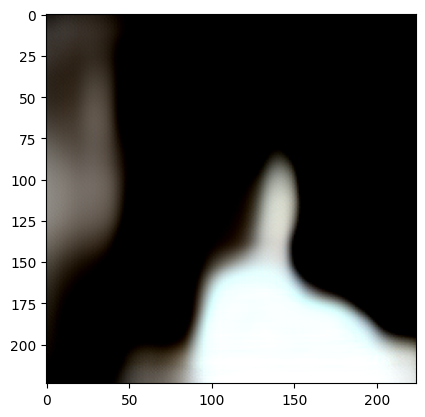

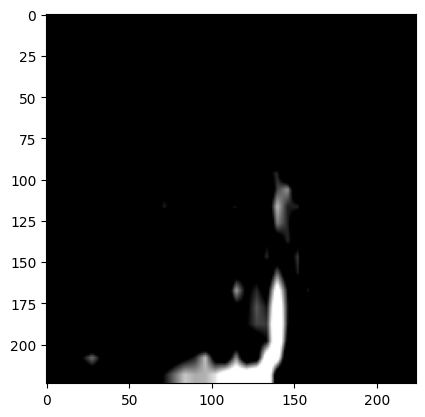

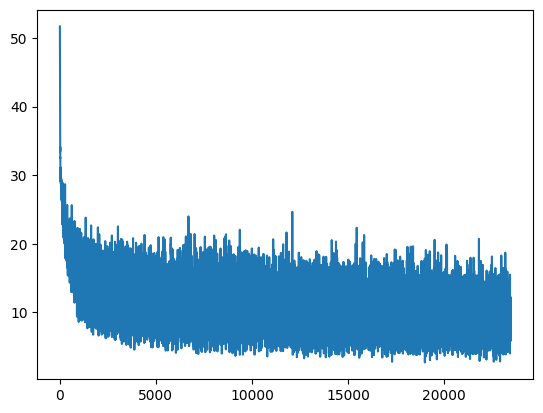

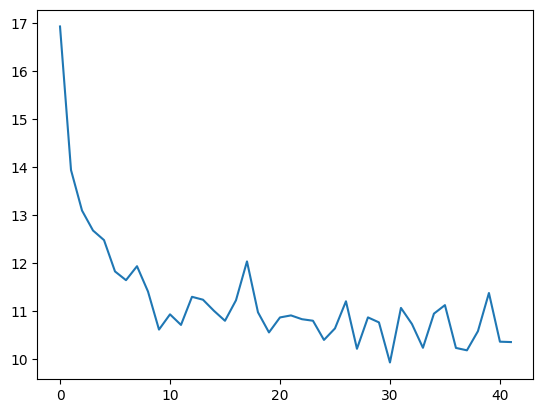

  2%|█████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 1/60 [16:55<16:38:13, 1015.15s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a3d87d0>, test/blurry_pixcorr=0.47, test/loss=10.3, test/loss_clip_total=0.453, test/loss_prior=0.33, test/num_steps=42, test/test_bwd_pct_correct=0.848, test/test_fwd_pct_correct=0.867, train/blurry_pixcorr=0.811, train/bwd_pct_correct=0.999, train/fwd_pct_correct=1, train/loss=9.15, train/loss_

[E41/100 I0/559]
  Loss 12.715006828308105
[E41/100 I50/559]
  Loss 6.950801372528076
[E41/100 I100/559]
  Loss 9.633447647094727
[E41/100 I150/559]
  Loss 6.4684906005859375
[E41/100 I200/559]
  Loss 4.320278167724609
[E41/100 I250/559]
  Loss 10.609808921813965
[E41/100 I300/559]
  Loss 6.849915504455566
[E41/100 I350/559]
  Loss 5.353178977966309
[E41/100 I400/559]
  Loss 10.563645362854004
[E41/100 I450/559]
  Loss 11.31409740447998
[E41/100 I500/559]
  Loss 8.289244651794434
[E41/100 I550/559]
  Loss 10.060067176818848

---Evaluating---



  2%|█████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 1/60 [31:51<16:38:13, 1015.15s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7a8750>, test/blurry_pixcorr=0.468, test/loss=10.4, test/loss_clip_total=0.397, test/loss_prior=0.332, test/num_steps=43, test/test_bwd_pct_correct=0.869, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.814, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.05, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 41 / 100


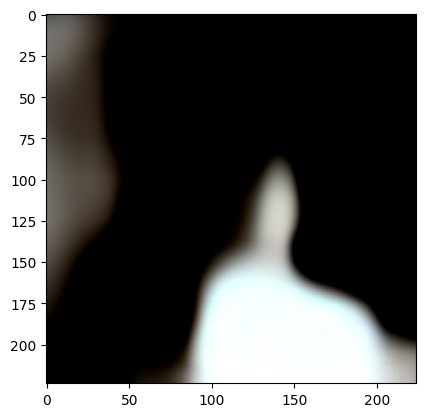

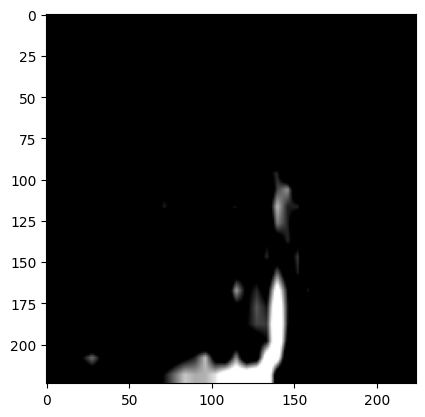

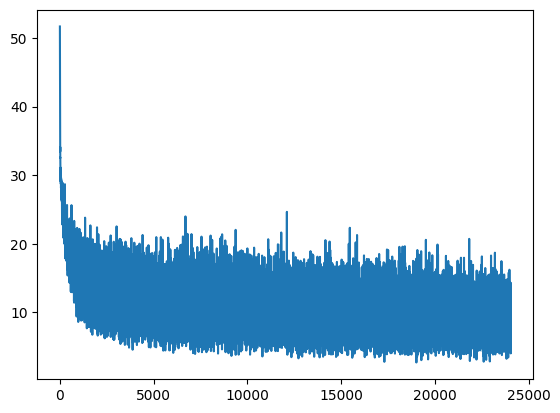

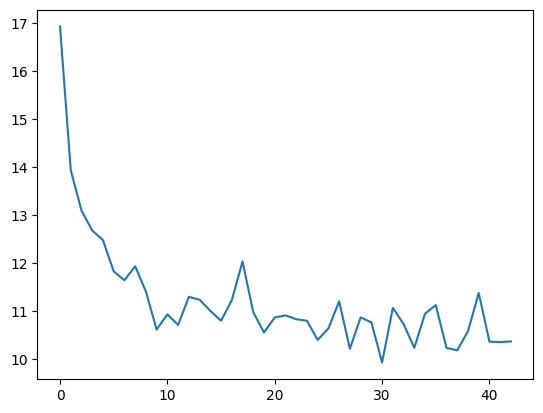

  3%|███████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 2/60 [32:08<15:23:37, 955.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7a8750>, test/blurry_pixcorr=0.468, test/loss=10.4, test/loss_clip_total=0.397, test/loss_prior=0.332, test/num_steps=43, test/test_bwd_pct_correct=0.869, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.814, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.05, train/loss_

[E42/100 I0/559]
  Loss 9.828459739685059
[E42/100 I50/559]
  Loss 7.675451755523682
[E42/100 I100/559]
  Loss 8.527037620544434
[E42/100 I150/559]
  Loss 5.06828498840332
[E42/100 I200/559]
  Loss 3.9905343055725098
[E42/100 I250/559]
  Loss 11.342498779296875
[E42/100 I300/559]
  Loss 8.136869430541992
[E42/100 I350/559]
  Loss 5.986595153808594
[E42/100 I400/559]
  Loss 8.59902572631836
[E42/100 I450/559]
  Loss 8.048891067504883
[E42/100 I500/559]
  Loss 7.563819885253906
[E42/100 I550/559]
  Loss 12.393598556518555

---Evaluating---



  3%|███████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 2/60 [47:04<15:23:37, 955.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7e2d50>, test/blurry_pixcorr=0.468, test/loss=10.7, test/loss_clip_total=0.394, test/loss_prior=0.345, test/num_steps=44, test/test_bwd_pct_correct=0.856, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.809, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.15, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 42 / 100


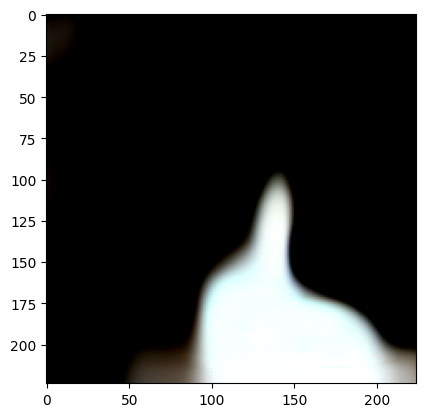

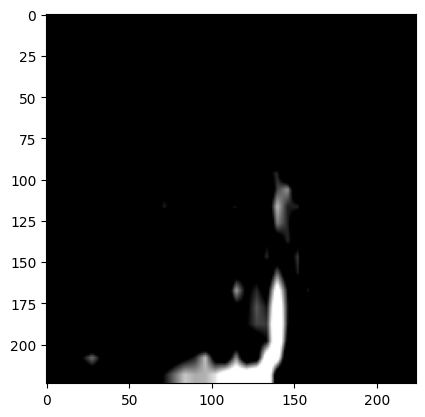

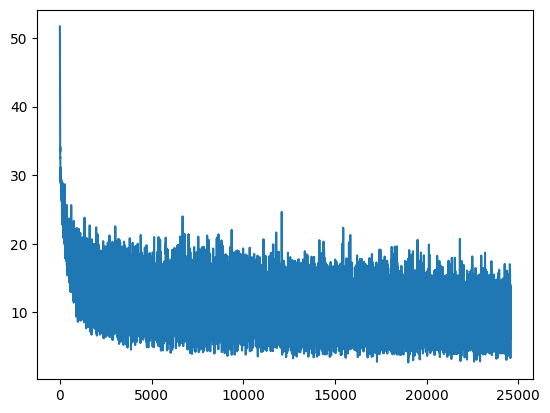

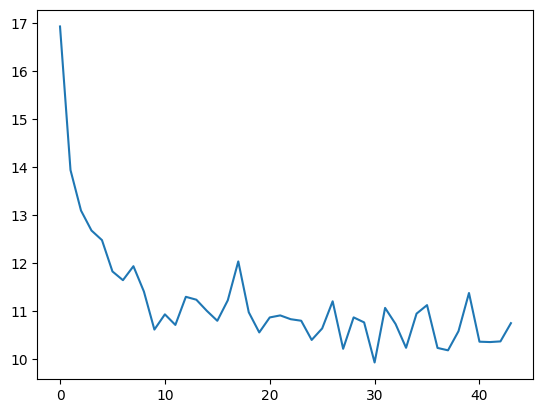

  5%|█████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 3/60 [47:11<14:44:53, 931.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7e2d50>, test/blurry_pixcorr=0.468, test/loss=10.7, test/loss_clip_total=0.394, test/loss_prior=0.345, test/num_steps=44, test/test_bwd_pct_correct=0.856, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.809, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.15, train/loss_b

[E43/100 I0/559]
  Loss 3.301774024963379
[E43/100 I50/559]
  Loss 12.132325172424316
[E43/100 I100/559]
  Loss 5.524360656738281
[E43/100 I150/559]
  Loss 5.760221481323242
[E43/100 I200/559]
  Loss 13.634587287902832
[E43/100 I250/559]
  Loss 10.25305461883545
[E43/100 I300/559]
  Loss 10.299885749816895
[E43/100 I350/559]
  Loss 11.135369300842285
[E43/100 I400/559]
  Loss 12.236662864685059
[E43/100 I450/559]
  Loss 4.235602855682373
[E43/100 I500/559]
  Loss 11.443696022033691
[E43/100 I550/559]
  Loss 11.897981643676758

---Evaluating---



  5%|█████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 3/60 [1:02:08<14:44:53, 931.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e558a90>, test/blurry_pixcorr=0.465, test/loss=11, test/loss_clip_total=0.373, test/loss_prior=0.355, test/num_steps=45, test/test_bwd_pct_correct=0.867, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.816, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.83, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 43 / 100


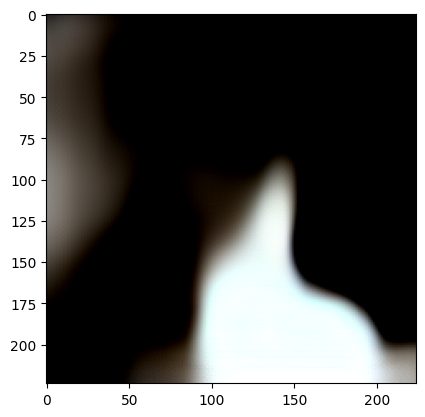

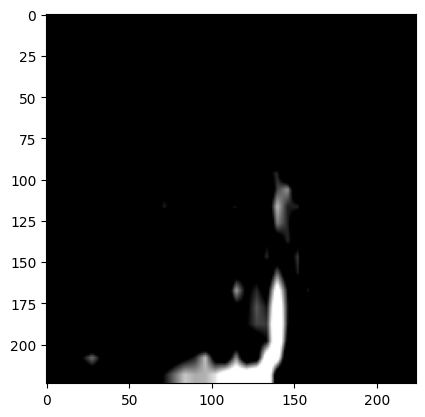

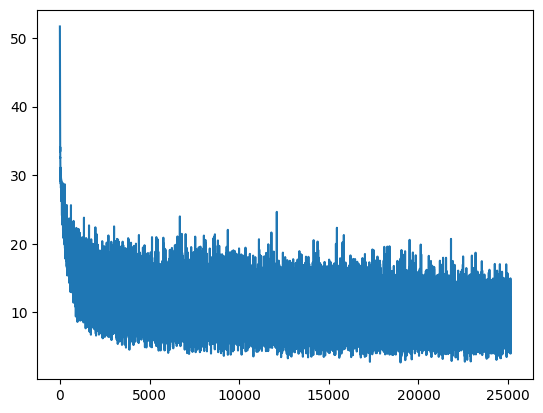

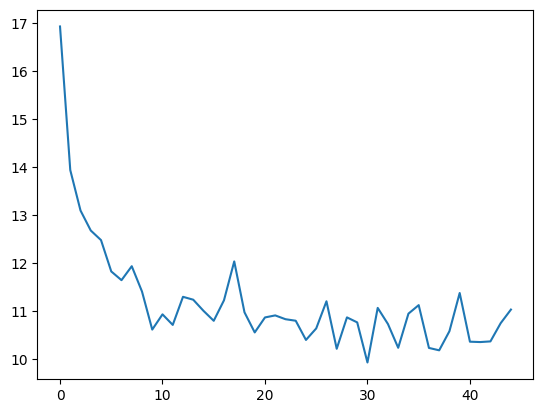

  7%|███████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 4/60 [1:02:15<14:19:14, 920.61s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e558a90>, test/blurry_pixcorr=0.465, test/loss=11, test/loss_clip_total=0.373, test/loss_prior=0.355, test/num_steps=45, test/test_bwd_pct_correct=0.867, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.816, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.83, train/loss_b

[E44/100 I0/559]
  Loss 10.15483283996582
[E44/100 I50/559]
  Loss 9.869843482971191
[E44/100 I100/559]
  Loss 9.781338691711426
[E44/100 I150/559]
  Loss 9.508356094360352
[E44/100 I200/559]
  Loss 13.011039733886719
[E44/100 I250/559]
  Loss 10.709481239318848
[E44/100 I300/559]
  Loss 5.579484939575195
[E44/100 I350/559]
  Loss 5.4880051612854
[E44/100 I400/559]
  Loss 10.267777442932129
[E44/100 I450/559]
  Loss 11.594686508178711
[E44/100 I500/559]
  Loss 9.210031509399414
[E44/100 I550/559]
  Loss 8.528173446655273

---Evaluating---



  7%|███████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 4/60 [1:17:11<14:19:14, 920.61s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e6c9bd0>, test/blurry_pixcorr=0.467, test/loss=11.3, test/loss_clip_total=0.424, test/loss_prior=0.362, test/num_steps=46, test/test_bwd_pct_correct=0.852, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.821, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.86, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep44 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 44 / 100


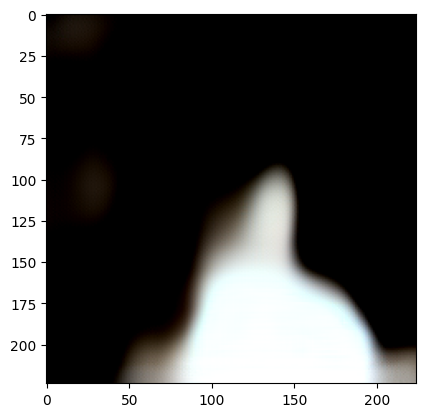

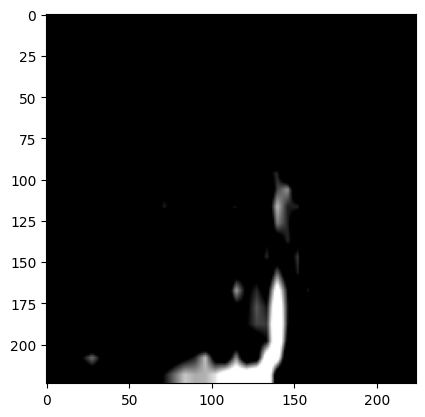

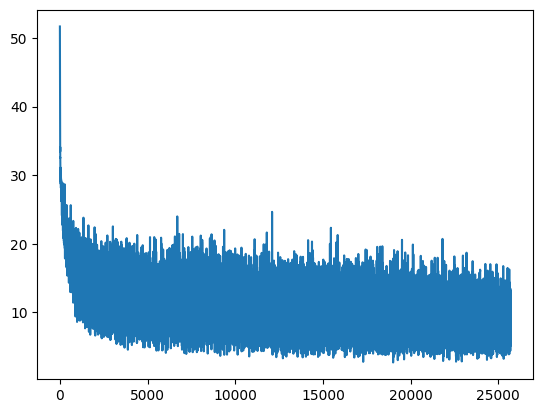

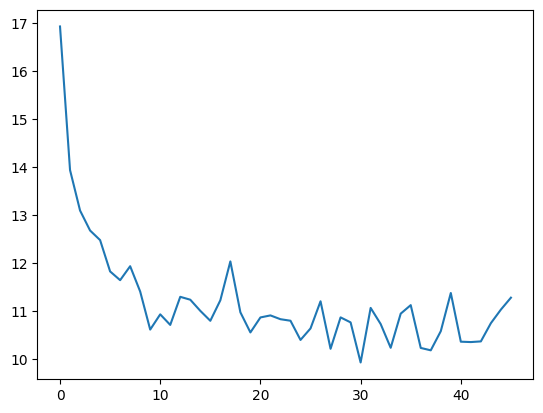

  8%|█████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 5/60 [1:17:25<14:00:18, 916.69s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e6c9bd0>, test/blurry_pixcorr=0.467, test/loss=11.3, test/loss_clip_total=0.424, test/loss_prior=0.362, test/num_steps=46, test/test_bwd_pct_correct=0.852, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.821, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.86, train/loss_b

[E45/100 I0/559]
  Loss 8.526227951049805
[E45/100 I50/559]
  Loss 9.439976692199707
[E45/100 I100/559]
  Loss 12.246780395507812
[E45/100 I150/559]
  Loss 8.174765586853027
[E45/100 I200/559]
  Loss 9.765799522399902
[E45/100 I250/559]
  Loss 9.378899574279785
[E45/100 I300/559]
  Loss 7.8909783363342285
[E45/100 I350/559]
  Loss 12.255012512207031
[E45/100 I400/559]
  Loss 8.131612777709961
[E45/100 I450/559]
  Loss 9.342947959899902
[E45/100 I500/559]
  Loss 4.526235580444336
[E45/100 I550/559]
  Loss 7.490591049194336

---Evaluating---



  8%|█████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 5/60 [1:32:21<14:00:18, 916.69s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a3f2a90>, test/blurry_pixcorr=0.466, test/loss=10.9, test/loss_clip_total=0.394, test/loss_prior=0.35, test/num_steps=47, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.823, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.81, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 45 / 100


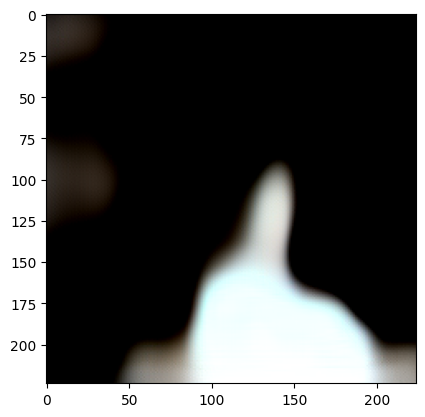

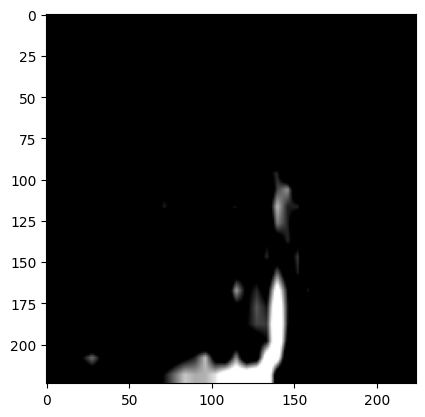

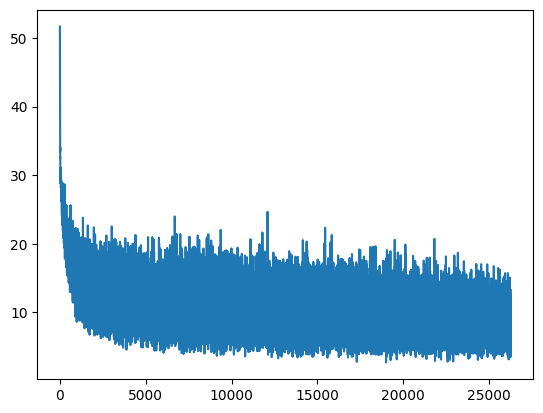

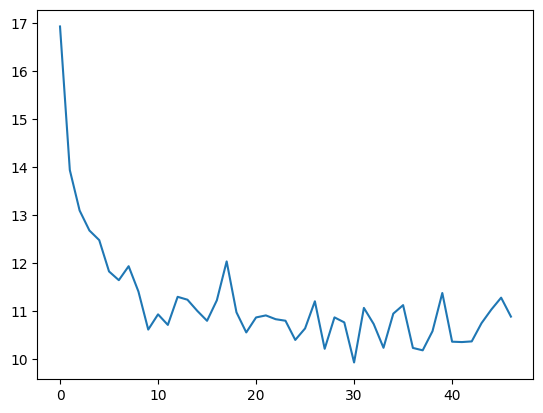

 10%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 6/60 [1:32:29<13:41:01, 912.24s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a3f2a90>, test/blurry_pixcorr=0.466, test/loss=10.9, test/loss_clip_total=0.394, test/loss_prior=0.35, test/num_steps=47, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.823, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.81, train/loss_b

[E46/100 I0/559]
  Loss 8.74350357055664
[E46/100 I50/559]
  Loss 4.589742183685303
[E46/100 I100/559]
  Loss 9.4483642578125
[E46/100 I150/559]
  Loss 5.973380088806152
[E46/100 I200/559]
  Loss 8.387995719909668
[E46/100 I250/559]
  Loss 7.996306896209717
[E46/100 I300/559]
  Loss 11.303983688354492
[E46/100 I350/559]
  Loss 10.248443603515625
[E46/100 I400/559]
  Loss 7.877079010009766
[E46/100 I450/559]
  Loss 10.272950172424316
[E46/100 I500/559]
  Loss 9.995924949645996
[E46/100 I550/559]
  Loss 8.411637306213379

---Evaluating---



 10%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 6/60 [1:47:25<13:41:01, 912.24s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5b5f50>, test/blurry_pixcorr=0.464, test/loss=10.8, test/loss_clip_total=0.374, test/loss_prior=0.348, test/num_steps=48, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.828, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.62, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 46 / 100


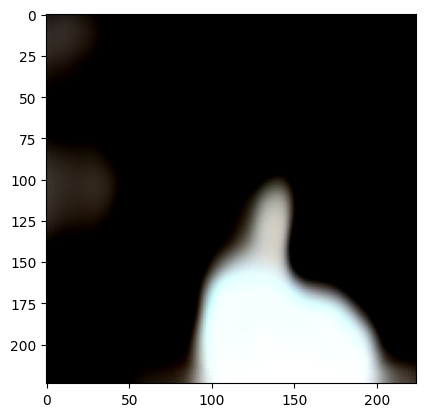

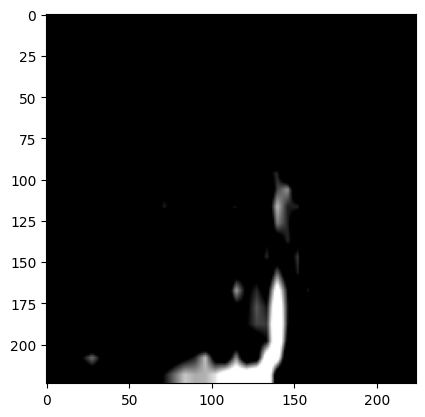

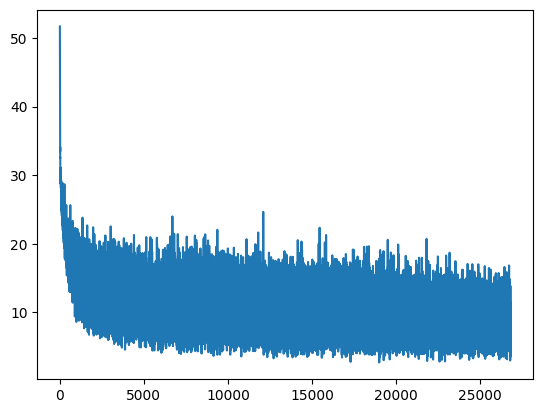

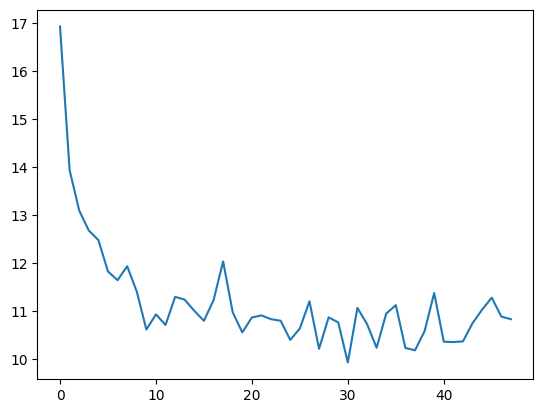

 12%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 7/60 [1:47:33<13:23:25, 909.55s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5b5f50>, test/blurry_pixcorr=0.464, test/loss=10.8, test/loss_clip_total=0.374, test/loss_prior=0.348, test/num_steps=48, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.828, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.62, train/loss_

[E47/100 I0/559]
  Loss 5.635635852813721
[E47/100 I50/559]
  Loss 8.412665367126465
[E47/100 I100/559]
  Loss 6.599545001983643
[E47/100 I150/559]
  Loss 8.096785545349121
[E47/100 I200/559]
  Loss 9.014251708984375
[E47/100 I250/559]
  Loss 8.403169631958008
[E47/100 I300/559]
  Loss 9.366789817810059
[E47/100 I350/559]
  Loss 6.871951580047607
[E47/100 I400/559]
  Loss 10.707826614379883
[E47/100 I450/559]
  Loss 8.675285339355469
[E47/100 I500/559]
  Loss 8.4584321975708
[E47/100 I550/559]
  Loss 8.737735748291016

---Evaluating---



 12%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 7/60 [2:02:28<13:23:25, 909.55s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a1ac5d0>, test/blurry_pixcorr=0.467, test/loss=11.3, test/loss_clip_total=0.408, test/loss_prior=0.363, test/num_steps=49, test/test_bwd_pct_correct=0.862, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.835, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.64, train/l


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 47 / 100


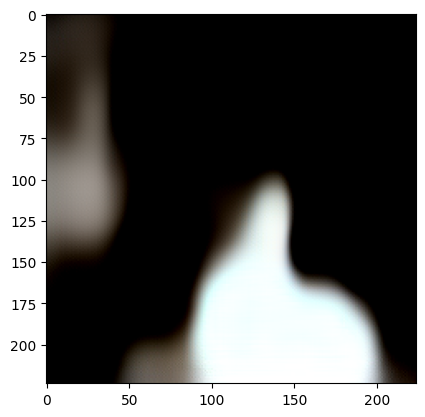

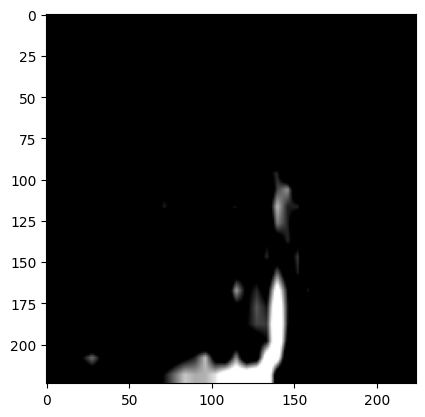

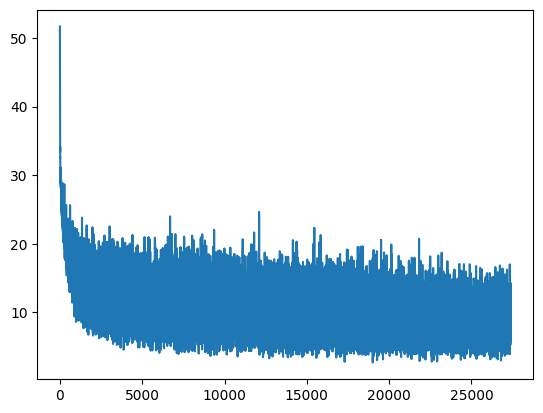

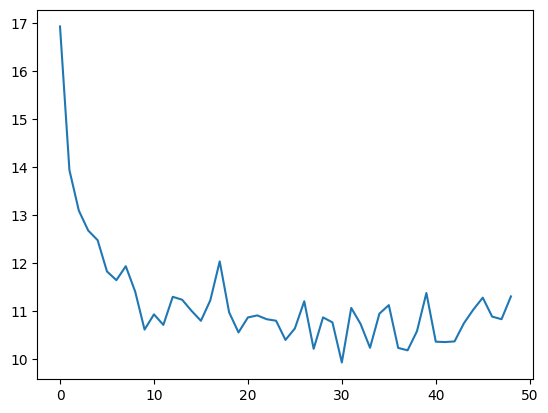

 13%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 8/60 [2:02:36<13:06:28, 907.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a1ac5d0>, test/blurry_pixcorr=0.467, test/loss=11.3, test/loss_clip_total=0.408, test/loss_prior=0.363, test/num_steps=49, test/test_bwd_pct_correct=0.862, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.835, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.64, train/l

[E48/100 I0/559]
  Loss 7.709678649902344
[E48/100 I50/559]
  Loss 4.274118423461914
[E48/100 I100/559]
  Loss 9.092439651489258
[E48/100 I150/559]
  Loss 10.222905158996582
[E48/100 I200/559]
  Loss 10.278101921081543
[E48/100 I250/559]
  Loss 16.256502151489258
[E48/100 I300/559]
  Loss 7.7261223793029785
[E48/100 I350/559]
  Loss 10.508841514587402
[E48/100 I400/559]
  Loss 7.930009365081787
[E48/100 I450/559]
  Loss 5.685235023498535
[E48/100 I500/559]
  Loss 8.217081069946289
[E48/100 I550/559]
  Loss 8.577540397644043

---Evaluating---



 13%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 8/60 [2:17:32<13:06:28, 907.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a399350>, test/blurry_pixcorr=0.466, test/loss=10.8, test/loss_clip_total=0.394, test/loss_prior=0.345, test/num_steps=50, test/test_bwd_pct_correct=0.86, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.831, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.71, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 48 / 100


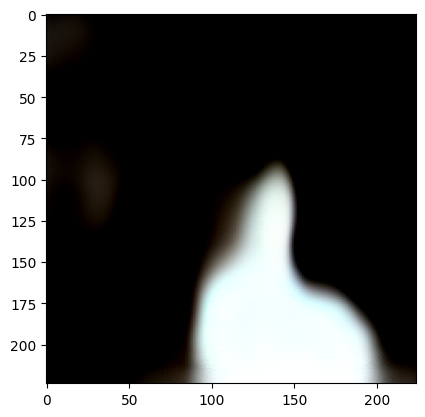

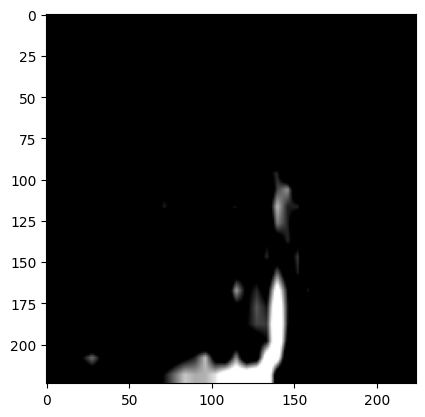

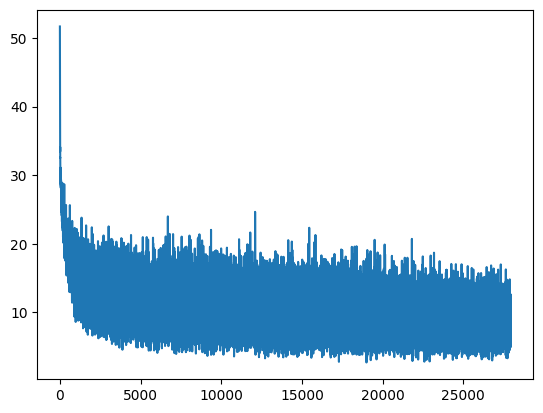

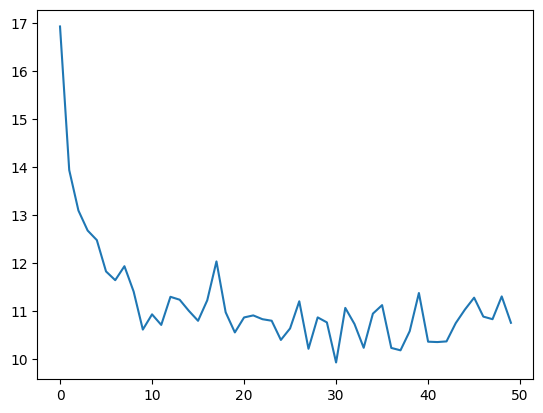

 15%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 9/60 [2:17:39<12:50:15, 906.19s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a399350>, test/blurry_pixcorr=0.466, test/loss=10.8, test/loss_clip_total=0.394, test/loss_prior=0.345, test/num_steps=50, test/test_bwd_pct_correct=0.86, test/test_fwd_pct_correct=0.883, train/blurry_pixcorr=0.831, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.71, train/loss_b

[E49/100 I0/559]
  Loss 9.716524124145508
[E49/100 I50/559]
  Loss 9.678006172180176
[E49/100 I100/559]
  Loss 5.106809139251709
[E49/100 I150/559]
  Loss 7.902317523956299
[E49/100 I200/559]
  Loss 6.2598795890808105
[E49/100 I250/559]
  Loss 4.97027063369751
[E49/100 I300/559]
  Loss 10.654767990112305
[E49/100 I350/559]
  Loss 18.931222915649414
[E49/100 I400/559]
  Loss 10.45051097869873
[E49/100 I450/559]
  Loss 7.6297383308410645
[E49/100 I500/559]
  Loss 7.66703987121582
[E49/100 I550/559]
  Loss 8.618667602539062

---Evaluating---



 15%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 9/60 [2:32:36<12:50:15, 906.19s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a14c4d0>, test/blurry_pixcorr=0.467, test/loss=9.93, test/loss_clip_total=0.405, test/loss_prior=0.318, test/num_steps=51, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.83, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.55, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep49 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 49 / 100


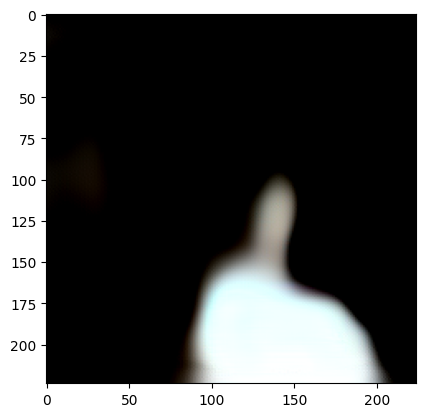

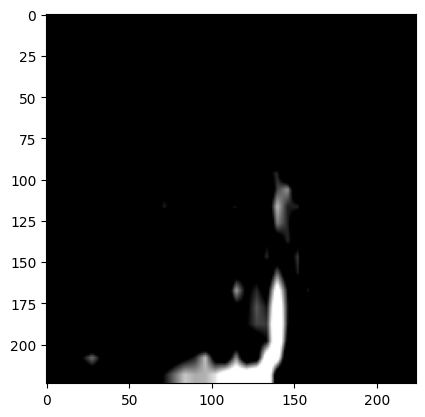

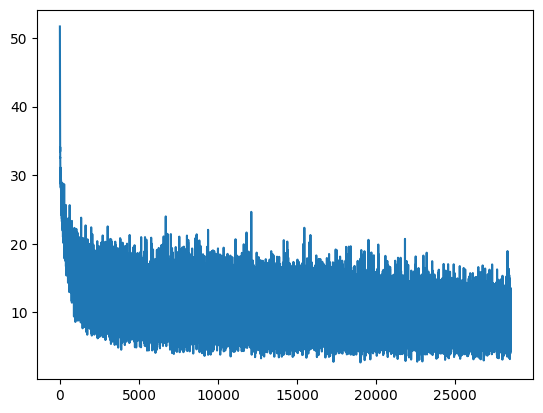

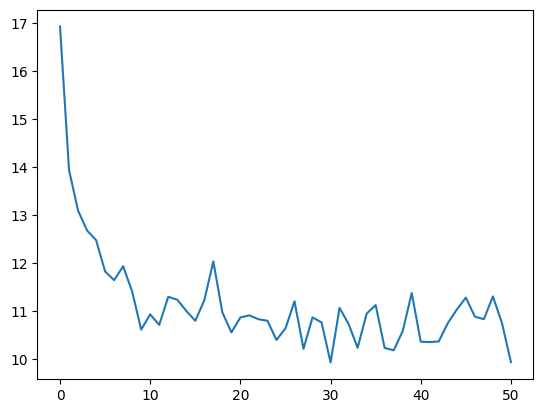

 17%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 10/60 [2:32:50<12:36:26, 907.73s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a14c4d0>, test/blurry_pixcorr=0.467, test/loss=9.93, test/loss_clip_total=0.405, test/loss_prior=0.318, test/num_steps=51, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.83, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.55, train/loss_

[E50/100 I0/559]
  Loss 10.006155967712402
[E50/100 I50/559]
  Loss 13.109296798706055
[E50/100 I100/559]
  Loss 11.010095596313477
[E50/100 I150/559]
  Loss 9.375341415405273
[E50/100 I200/559]
  Loss 5.809739589691162
[E50/100 I250/559]
  Loss 7.446061611175537
[E50/100 I300/559]
  Loss 8.60607624053955
[E50/100 I350/559]
  Loss 12.025561332702637
[E50/100 I400/559]
  Loss 5.972284317016602
[E50/100 I450/559]
  Loss 7.907094955444336
[E50/100 I500/559]
  Loss 6.824016094207764
[E50/100 I550/559]
  Loss 10.950333595275879

---Evaluating---



 17%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 10/60 [2:47:46<12:36:26, 907.73s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f92cc7b87d0>, test/blurry_pixcorr=0.464, test/loss=10.5, test/loss_clip_total=0.389, test/loss_prior=0.337, test/num_steps=52, test/test_bwd_pct_correct=0.887, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.838, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.4, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 50 / 100


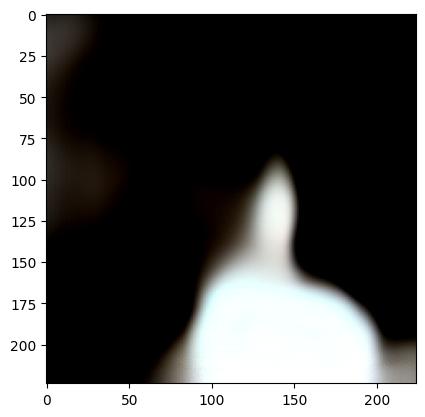

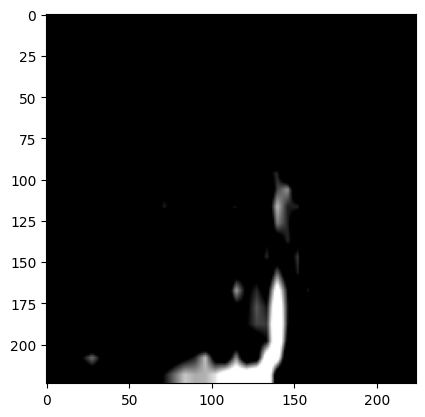

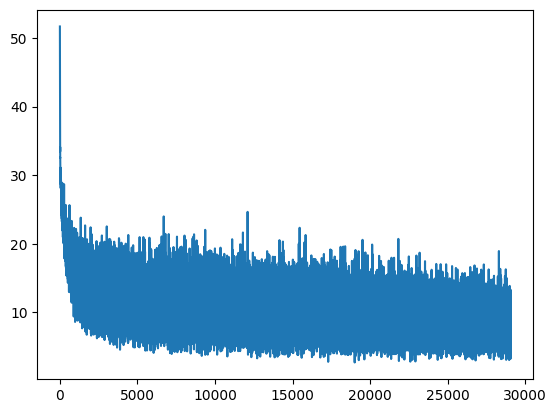

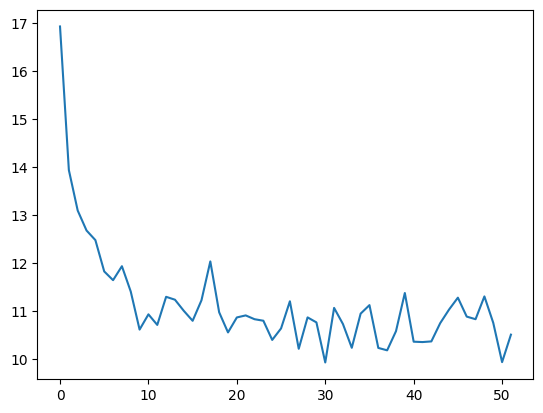

 18%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 11/60 [2:47:55<12:20:29, 906.72s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f92cc7b87d0>, test/blurry_pixcorr=0.464, test/loss=10.5, test/loss_clip_total=0.389, test/loss_prior=0.337, test/num_steps=52, test/test_bwd_pct_correct=0.887, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.838, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.4, train/loss

[E51/100 I0/559]
  Loss 8.866681098937988
[E51/100 I50/559]
  Loss 8.604865074157715
[E51/100 I100/559]
  Loss 7.35279655456543
[E51/100 I150/559]
  Loss 7.280191898345947
[E51/100 I200/559]
  Loss 7.229842185974121
[E51/100 I250/559]
  Loss 5.4035162925720215
[E51/100 I300/559]
  Loss 9.141809463500977
[E51/100 I350/559]
  Loss 8.264920234680176
[E51/100 I400/559]
  Loss 8.709634780883789
[E51/100 I450/559]
  Loss 12.21235466003418
[E51/100 I500/559]
  Loss 6.546459674835205
[E51/100 I550/559]
  Loss 10.503523826599121

---Evaluating---



 18%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 11/60 [3:02:52<12:20:29, 906.72s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e53c2d0>, test/blurry_pixcorr=0.464, test/loss=10.3, test/loss_clip_total=0.413, test/loss_prior=0.331, test/num_steps=53, test/test_bwd_pct_correct=0.867, test/test_fwd_pct_correct=0.873, train/blurry_pixcorr=0.838, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.41, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 51 / 100


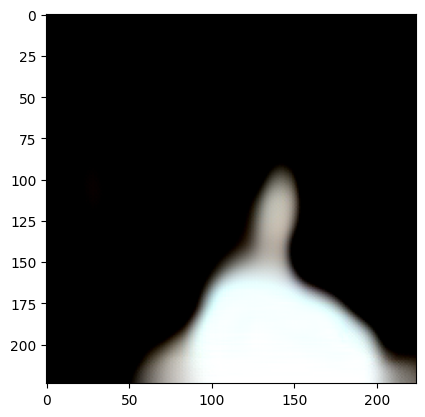

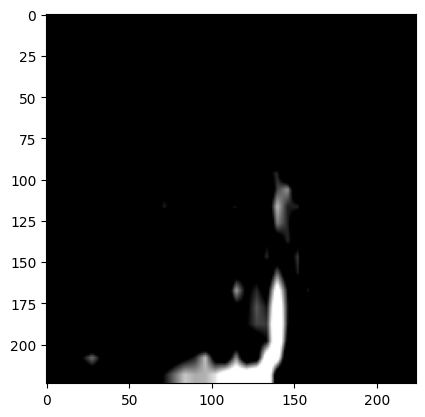

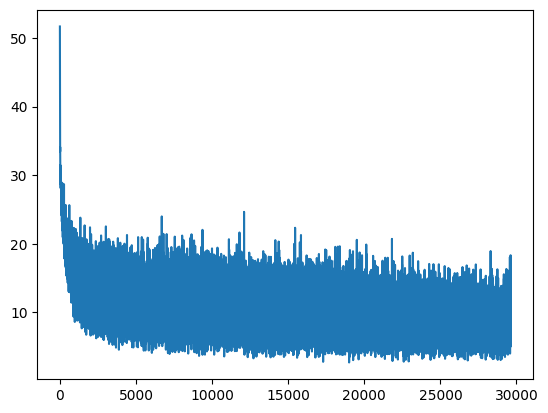

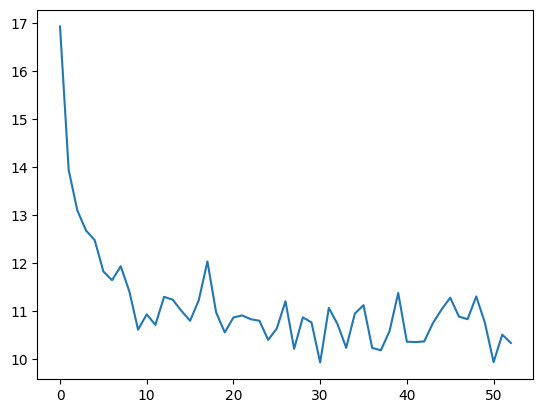

 20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 12/60 [3:02:59<12:04:51, 906.08s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e53c2d0>, test/blurry_pixcorr=0.464, test/loss=10.3, test/loss_clip_total=0.413, test/loss_prior=0.331, test/num_steps=53, test/test_bwd_pct_correct=0.867, test/test_fwd_pct_correct=0.873, train/blurry_pixcorr=0.838, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.41, train/loss

[E52/100 I0/559]
  Loss 8.428508758544922
[E52/100 I50/559]
  Loss 9.607158660888672
[E52/100 I100/559]
  Loss 7.2498579025268555
[E52/100 I150/559]
  Loss 4.8934125900268555
[E52/100 I200/559]
  Loss 12.216108322143555
[E52/100 I250/559]
  Loss 6.415945053100586
[E52/100 I300/559]
  Loss 8.727023124694824
[E52/100 I350/559]
  Loss 8.707832336425781
[E52/100 I400/559]
  Loss 9.6571626663208
[E52/100 I450/559]
  Loss 8.947774887084961
[E52/100 I500/559]
  Loss 9.288755416870117
[E52/100 I550/559]
  Loss 9.448078155517578

---Evaluating---



 20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 12/60 [3:17:56<12:04:51, 906.08s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5afd50>, test/blurry_pixcorr=0.464, test/loss=10.9, test/loss_clip_total=0.393, test/loss_prior=0.351, test/num_steps=54, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.843, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.33, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 52 / 100


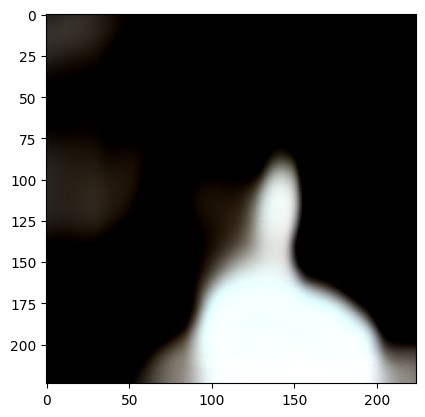

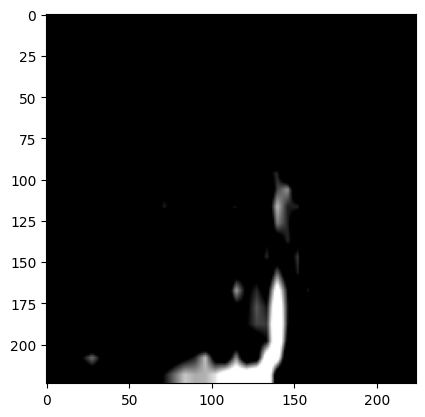

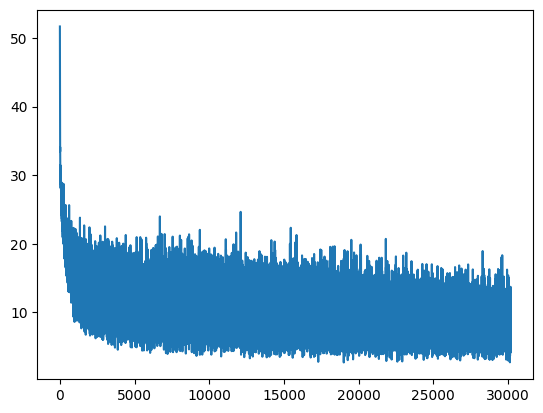

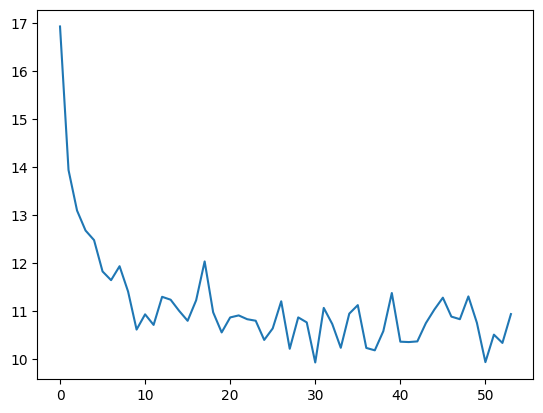

 22%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 13/60 [3:18:03<11:49:13, 905.40s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5afd50>, test/blurry_pixcorr=0.464, test/loss=10.9, test/loss_clip_total=0.393, test/loss_prior=0.351, test/num_steps=54, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.843, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.33, train/los

[E53/100 I0/559]
  Loss 9.708151817321777
[E53/100 I50/559]
  Loss 8.803976058959961
[E53/100 I100/559]
  Loss 7.211170196533203
[E53/100 I150/559]
  Loss 8.666634559631348
[E53/100 I200/559]
  Loss 8.068136215209961
[E53/100 I250/559]
  Loss 6.39560079574585
[E53/100 I300/559]
  Loss 6.748810768127441
[E53/100 I350/559]
  Loss 9.154488563537598
[E53/100 I400/559]
  Loss 3.405608654022217
[E53/100 I450/559]
  Loss 6.707996368408203
[E53/100 I500/559]
  Loss 10.914920806884766
[E53/100 I550/559]
  Loss 10.306167602539062

---Evaluating---



 22%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 13/60 [3:32:59<11:49:13, 905.40s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5f6610>, test/blurry_pixcorr=0.465, test/loss=11.1, test/loss_clip_total=0.393, test/loss_prior=0.357, test/num_steps=55, test/test_bwd_pct_correct=0.869, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.844, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.07, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 53 / 100


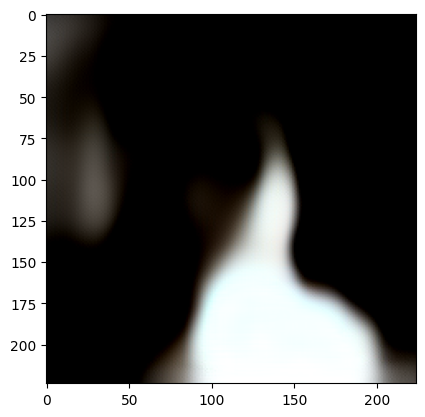

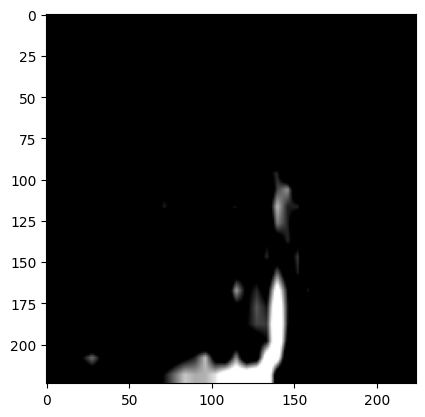

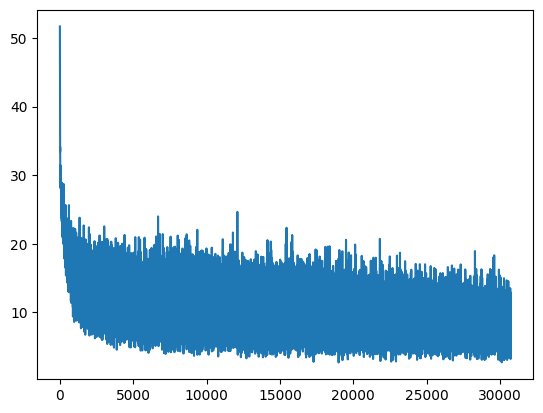

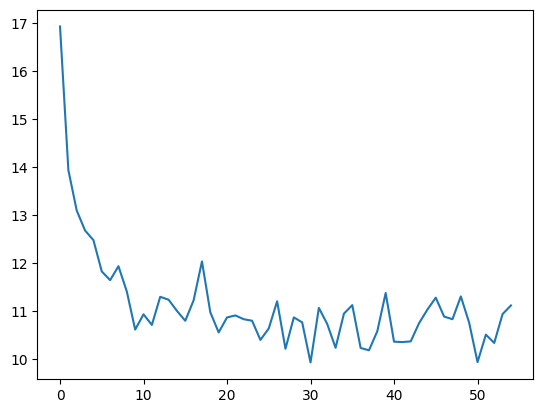

 23%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 14/60 [3:33:07<11:33:42, 904.83s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5f6610>, test/blurry_pixcorr=0.465, test/loss=11.1, test/loss_clip_total=0.393, test/loss_prior=0.357, test/num_steps=55, test/test_bwd_pct_correct=0.869, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.844, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.07, train/loss_b

[E54/100 I0/559]
  Loss 9.707538604736328
[E54/100 I50/559]
  Loss 8.134302139282227
[E54/100 I100/559]
  Loss 4.05661153793335
[E54/100 I150/559]
  Loss 5.0643086433410645
[E54/100 I200/559]
  Loss 4.848942756652832
[E54/100 I250/559]
  Loss 10.569074630737305
[E54/100 I300/559]
  Loss 7.222366809844971
[E54/100 I350/559]
  Loss 7.920492172241211
[E54/100 I400/559]
  Loss 10.696708679199219
[E54/100 I450/559]
  Loss 11.480520248413086
[E54/100 I500/559]
  Loss 5.689315319061279
[E54/100 I550/559]
  Loss 7.877547264099121

---Evaluating---



 23%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 14/60 [3:48:03<11:33:42, 904.83s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a120dd0>, test/blurry_pixcorr=0.464, test/loss=10.9, test/loss_clip_total=0.401, test/loss_prior=0.349, test/num_steps=56, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.842, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.96, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep54 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 54 / 100


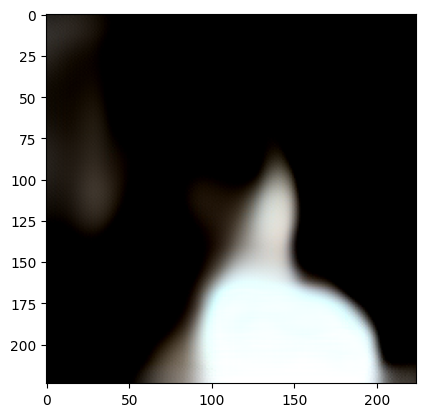

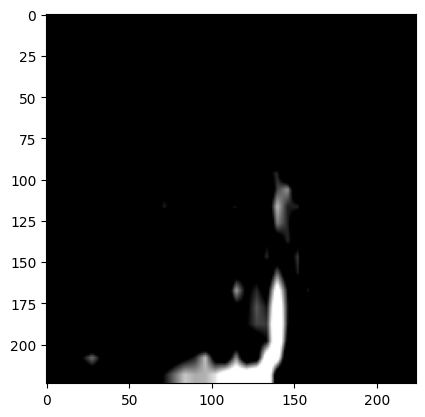

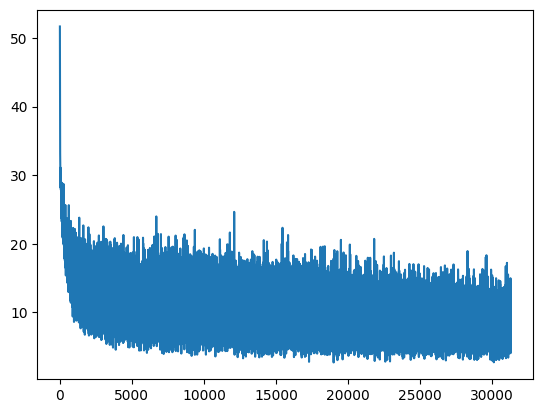

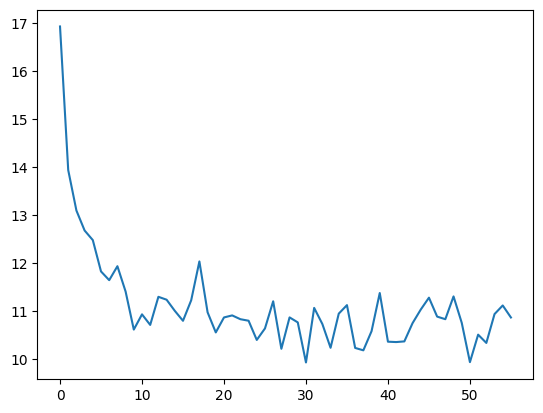

 25%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 15/60 [3:48:16<11:19:42, 906.27s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a120dd0>, test/blurry_pixcorr=0.464, test/loss=10.9, test/loss_clip_total=0.401, test/loss_prior=0.349, test/num_steps=56, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.842, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.96, train/loss_

[E55/100 I0/559]
  Loss 8.459067344665527
[E55/100 I50/559]
  Loss 9.929265022277832
[E55/100 I100/559]
  Loss 6.098753929138184
[E55/100 I150/559]
  Loss 4.156315803527832
[E55/100 I200/559]
  Loss 8.346946716308594
[E55/100 I250/559]
  Loss 8.650628089904785
[E55/100 I300/559]
  Loss 8.075758934020996
[E55/100 I350/559]
  Loss 6.187970161437988
[E55/100 I400/559]
  Loss 4.270305156707764
[E55/100 I450/559]
  Loss 9.059704780578613
[E55/100 I500/559]
  Loss 6.546426296234131
[E55/100 I550/559]
  Loss 10.439976692199707

---Evaluating---



 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 15/60 [4:03:12<11:19:42, 906.27s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e549190>, test/blurry_pixcorr=0.466, test/loss=10.7, test/loss_clip_total=0.445, test/loss_prior=0.342, test/num_steps=57, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.86, train/blurry_pixcorr=0.853, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.02, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 55 / 100


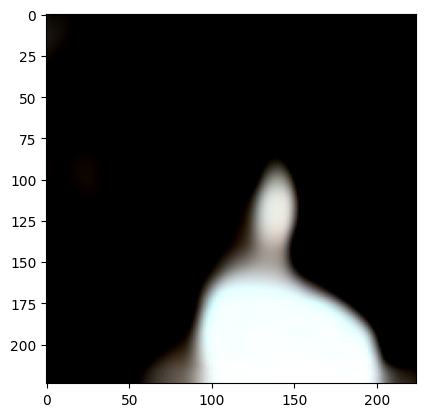

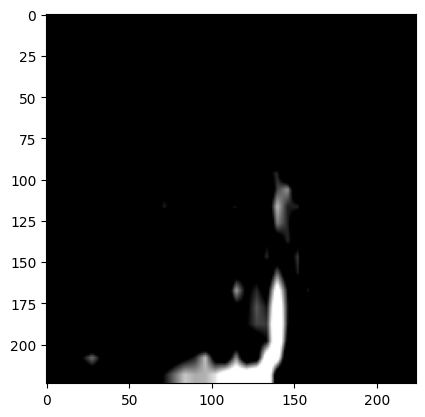

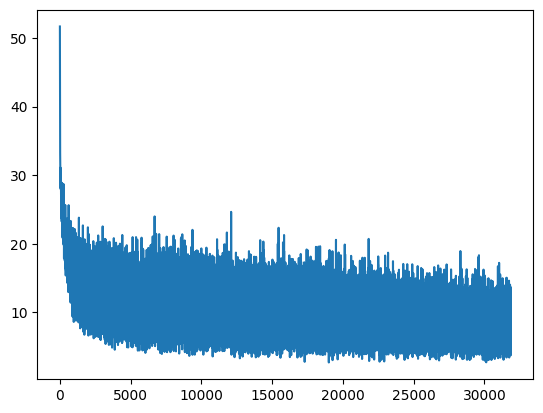

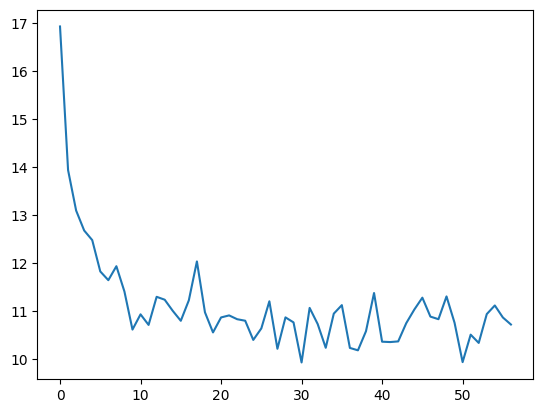

 27%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 16/60 [4:03:19<11:03:47, 905.18s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e549190>, test/blurry_pixcorr=0.466, test/loss=10.7, test/loss_clip_total=0.445, test/loss_prior=0.342, test/num_steps=57, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.86, train/blurry_pixcorr=0.853, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.02, train/lo

[E56/100 I0/559]
  Loss 9.125895500183105
[E56/100 I50/559]
  Loss 5.379936695098877
[E56/100 I100/559]
  Loss 8.662385940551758
[E56/100 I150/559]
  Loss 6.57356595993042
[E56/100 I200/559]
  Loss 4.285841941833496
[E56/100 I250/559]
  Loss 9.483986854553223
[E56/100 I300/559]
  Loss 9.794146537780762
[E56/100 I350/559]
  Loss 3.5771522521972656
[E56/100 I400/559]
  Loss 11.66767406463623
[E56/100 I450/559]
  Loss 7.970870018005371
[E56/100 I500/559]
  Loss 7.9553046226501465
[E56/100 I550/559]
  Loss 8.812331199645996

---Evaluating---



 27%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 16/60 [4:18:14<11:03:47, 905.18s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e744250>, test/blurry_pixcorr=0.464, test/loss=11.2, test/loss_clip_total=0.387, test/loss_prior=0.362, test/num_steps=58, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.86, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.75, train/l


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 56 / 100


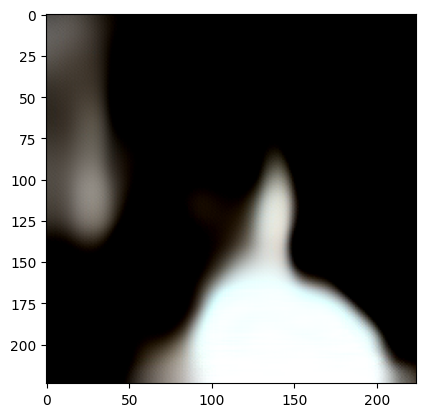

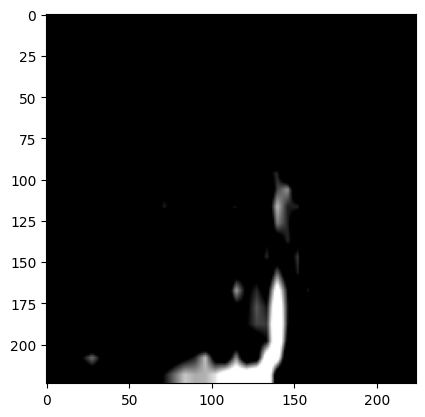

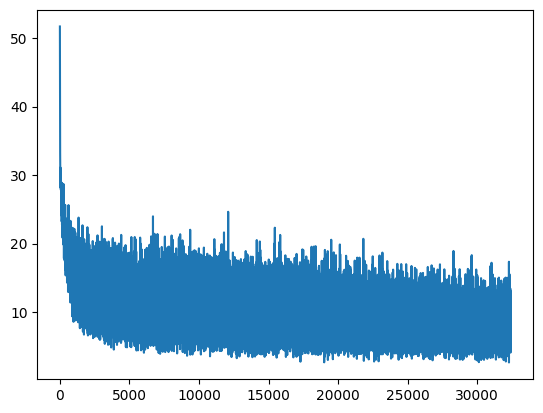

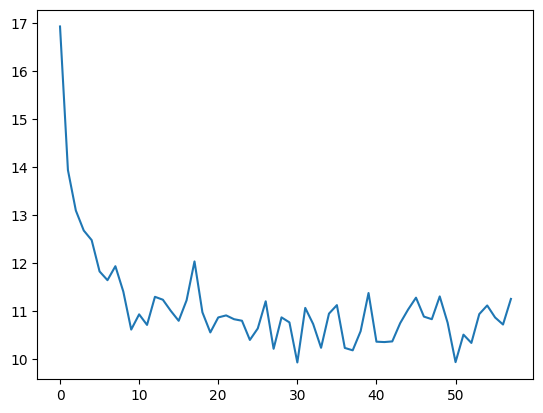

 28%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                            | 17/60 [4:18:21<10:48:04, 904.28s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e744250>, test/blurry_pixcorr=0.464, test/loss=11.2, test/loss_clip_total=0.387, test/loss_prior=0.362, test/num_steps=58, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.86, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.75, train/l

[E57/100 I0/559]
  Loss 9.817112922668457
[E57/100 I50/559]
  Loss 9.210494041442871
[E57/100 I100/559]
  Loss 7.499662399291992
[E57/100 I150/559]
  Loss 6.186246395111084
[E57/100 I200/559]
  Loss 8.561864852905273
[E57/100 I250/559]
  Loss 11.662342071533203
[E57/100 I300/559]
  Loss 9.717435836791992
[E57/100 I350/559]
  Loss 8.735457420349121
[E57/100 I400/559]
  Loss 6.940724849700928
[E57/100 I450/559]
  Loss 6.206538200378418
[E57/100 I500/559]
  Loss 8.218493461608887
[E57/100 I550/559]
  Loss 7.5537614822387695

---Evaluating---



 28%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                          | 17/60 [4:33:16<10:48:04, 904.28s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938b6a2b90>, test/blurry_pixcorr=0.461, test/loss=12.2, test/loss_clip_total=0.4, test/loss_prior=0.392, test/num_steps=59, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.869, train/blurry_pixcorr=0.857, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.87, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 57 / 100


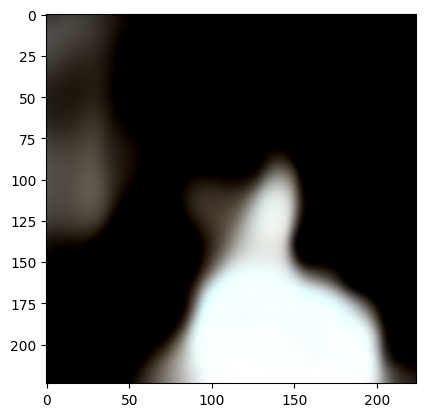

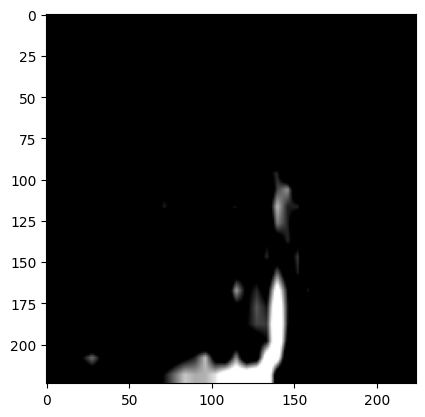

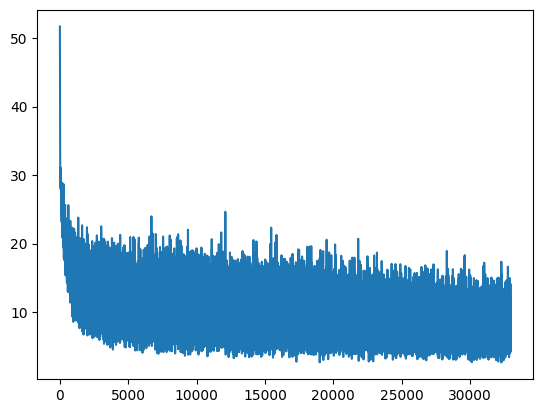

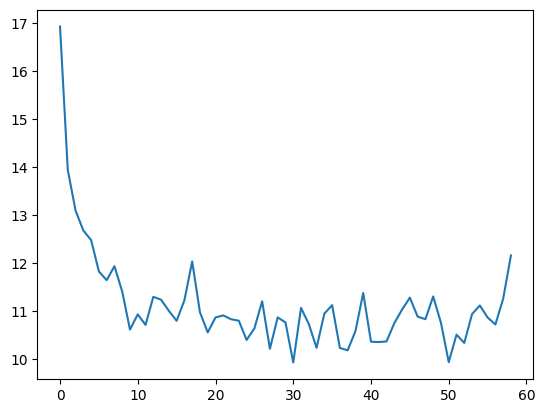

 30%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                | 18/60 [4:33:23<10:32:35, 903.70s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938b6a2b90>, test/blurry_pixcorr=0.461, test/loss=12.2, test/loss_clip_total=0.4, test/loss_prior=0.392, test/num_steps=59, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.869, train/blurry_pixcorr=0.857, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.87, train/loss_

[E58/100 I0/559]
  Loss 10.123618125915527
[E58/100 I50/559]
  Loss 7.662867069244385
[E58/100 I100/559]
  Loss 11.461716651916504
[E58/100 I150/559]
  Loss 3.825035572052002
[E58/100 I200/559]
  Loss 8.197057723999023
[E58/100 I250/559]
  Loss 8.196772575378418
[E58/100 I300/559]
  Loss 3.2501304149627686
[E58/100 I350/559]
  Loss 12.111787796020508
[E58/100 I400/559]
  Loss 6.163384914398193
[E58/100 I450/559]
  Loss 6.589006423950195
[E58/100 I500/559]
  Loss 8.94443416595459
[E58/100 I550/559]
  Loss 7.470534801483154

---Evaluating---



 30%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                               | 18/60 [4:48:19<10:32:35, 903.70s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a2532d0>, test/blurry_pixcorr=0.462, test/loss=11.1, test/loss_clip_total=0.401, test/loss_prior=0.358, test/num_steps=60, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.855, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.81, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 58 / 100


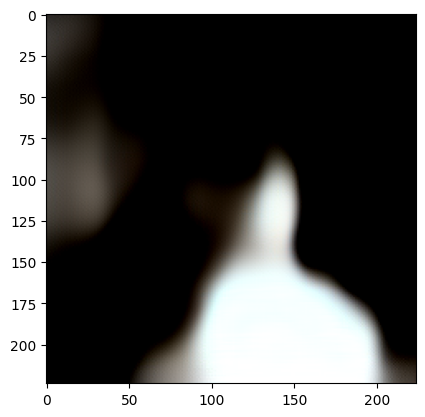

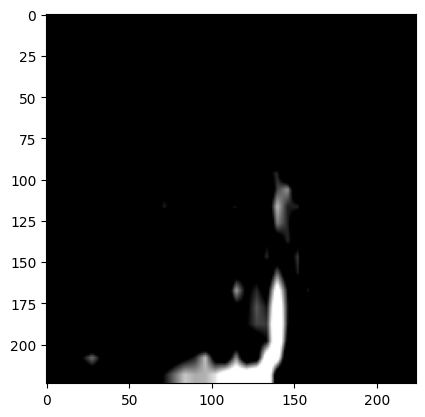

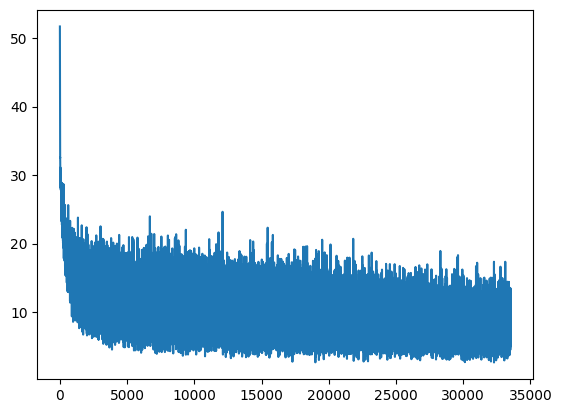

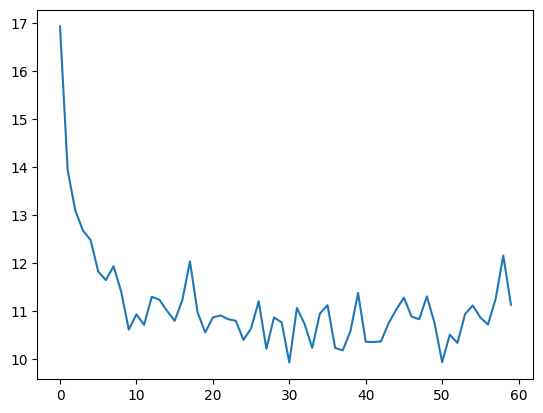

 32%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                     | 19/60 [4:48:26<10:17:15, 903.30s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a2532d0>, test/blurry_pixcorr=0.462, test/loss=11.1, test/loss_clip_total=0.401, test/loss_prior=0.358, test/num_steps=60, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.855, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.81, train/loss_

[E59/100 I0/559]
  Loss 8.652650833129883
[E59/100 I50/559]
  Loss 8.200339317321777
[E59/100 I100/559]
  Loss 7.363616943359375
[E59/100 I150/559]
  Loss 3.9712908267974854
[E59/100 I200/559]
  Loss 6.36208963394165
[E59/100 I250/559]
  Loss 6.813943862915039
[E59/100 I300/559]
  Loss 8.987825393676758
[E59/100 I350/559]
  Loss 3.871267080307007
[E59/100 I400/559]
  Loss 7.606647491455078
[E59/100 I450/559]
  Loss 7.015649318695068
[E59/100 I500/559]
  Loss 5.027519702911377
[E59/100 I550/559]
  Loss 9.457701683044434

---Evaluating---



 32%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                      | 19/60 [5:03:21<10:17:15, 903.30s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a430250>, test/blurry_pixcorr=0.463, test/loss=10.6, test/loss_clip_total=0.444, test/loss_prior=0.339, test/num_steps=61, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.865, train/blurry_pixcorr=0.852, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.6, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep59 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 59 / 100


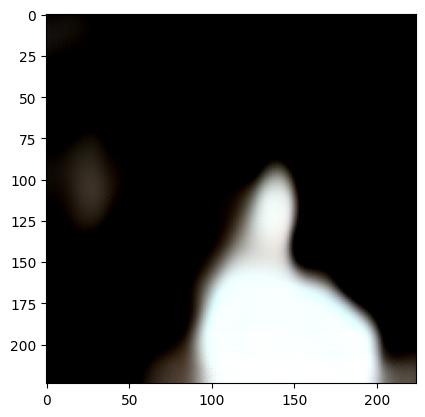

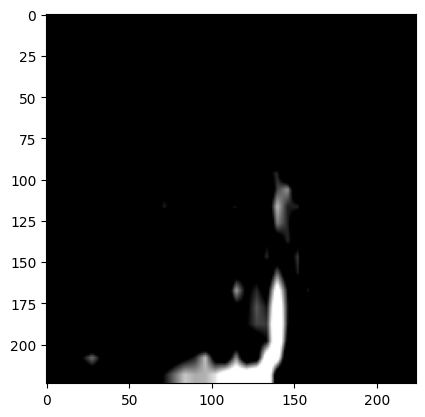

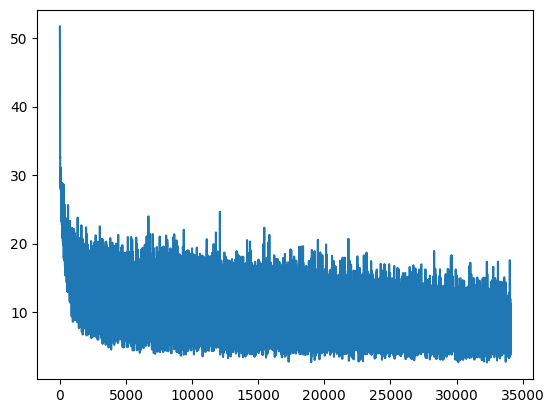

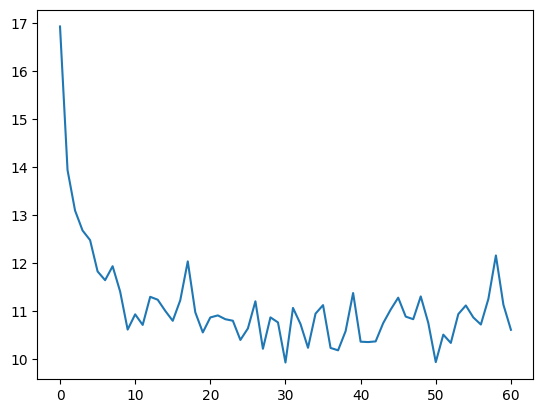

 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                            | 20/60 [5:03:35<10:03:20, 905.01s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a430250>, test/blurry_pixcorr=0.463, test/loss=10.6, test/loss_clip_total=0.444, test/loss_prior=0.339, test/num_steps=61, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.865, train/blurry_pixcorr=0.852, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.6, train/loss_

[E60/100 I0/559]
  Loss 7.321359634399414
[E60/100 I50/559]
  Loss 6.023937225341797
[E60/100 I100/559]
  Loss 5.08582067489624
[E60/100 I150/559]
  Loss 6.807820796966553
[E60/100 I200/559]
  Loss 10.586077690124512
[E60/100 I250/559]
  Loss 7.855638027191162
[E60/100 I300/559]
  Loss 10.36328125
[E60/100 I350/559]
  Loss 5.897951126098633
[E60/100 I400/559]
  Loss 8.387913703918457
[E60/100 I450/559]
  Loss 7.746618747711182
[E60/100 I500/559]
  Loss 7.508388996124268
[E60/100 I550/559]
  Loss 8.773499488830566

---Evaluating---



 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                            | 20/60 [5:18:29<10:03:20, 905.01s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a350110>, test/blurry_pixcorr=0.463, test/loss=11.1, test/loss_clip_total=0.395, test/loss_prior=0.355, test/num_steps=62, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.865, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.66, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 60 / 100


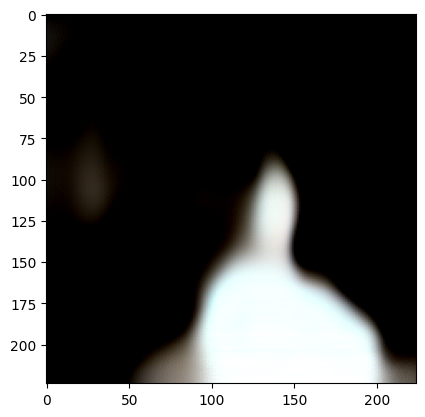

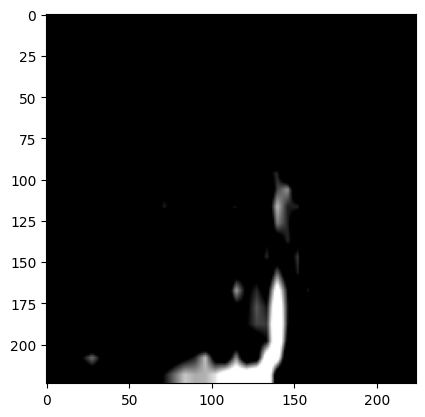

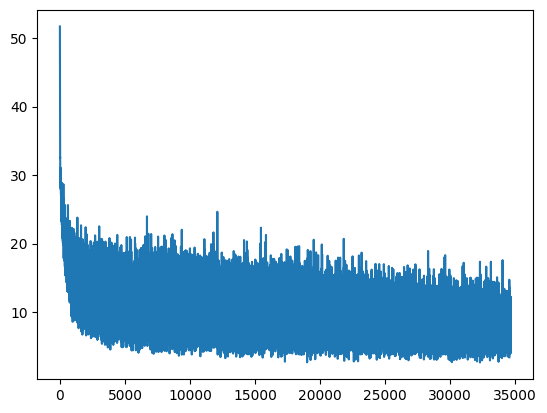

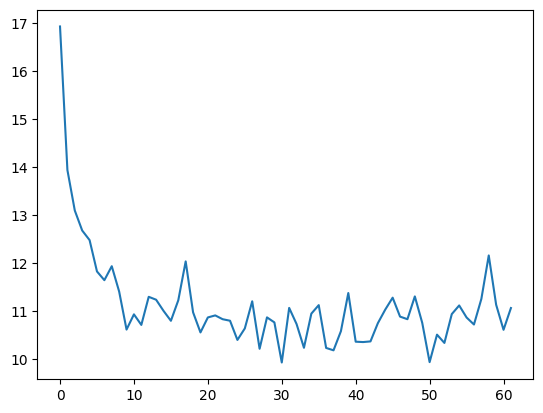

 35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                  | 21/60 [5:18:36<9:47:35, 903.98s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a350110>, test/blurry_pixcorr=0.463, test/loss=11.1, test/loss_clip_total=0.395, test/loss_prior=0.355, test/num_steps=62, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.865, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.66, train/loss

[E61/100 I0/559]
  Loss 6.892599105834961
[E61/100 I50/559]
  Loss 7.155305862426758
[E61/100 I100/559]
  Loss 6.344090461730957
[E61/100 I150/559]
  Loss 9.888572692871094
[E61/100 I200/559]
  Loss 6.762683391571045
[E61/100 I250/559]
  Loss 12.65648365020752
[E61/100 I300/559]
  Loss 9.41308879852295
[E61/100 I350/559]
  Loss 7.904012680053711
[E61/100 I400/559]
  Loss 4.634486675262451
[E61/100 I450/559]
  Loss 7.961940765380859
[E61/100 I500/559]
  Loss 6.756072998046875
[E61/100 I550/559]
  Loss 7.932243347167969

---Evaluating---



 35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                    | 21/60 [5:33:28<9:47:35, 903.98s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e68d910>, test/blurry_pixcorr=0.462, test/loss=11.1, test/loss_clip_total=0.398, test/loss_prior=0.357, test/num_steps=63, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.865, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.53, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 61 / 100


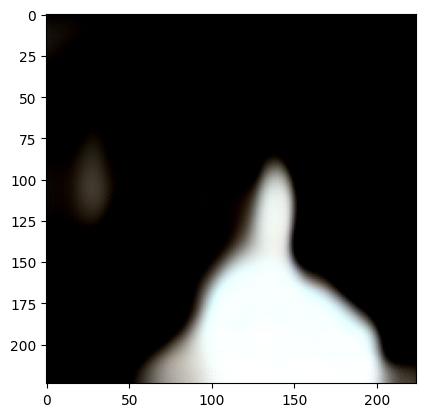

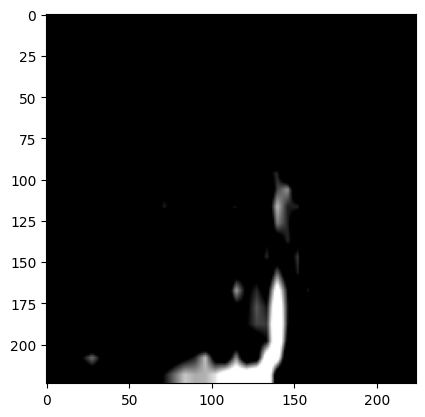

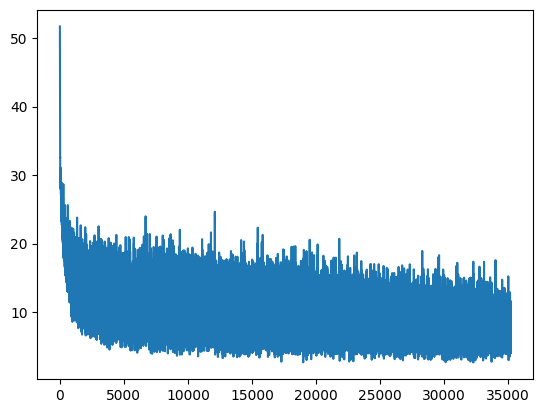

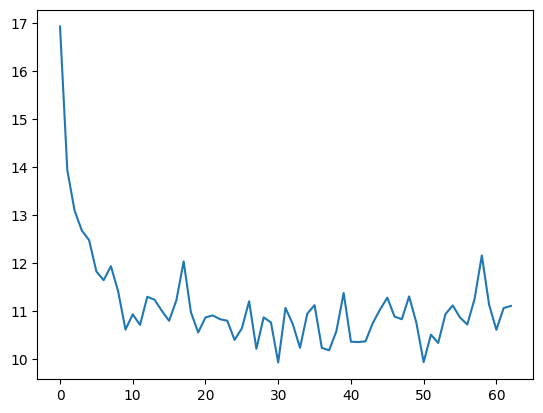

 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                          | 22/60 [5:33:35<9:31:37, 902.56s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e68d910>, test/blurry_pixcorr=0.462, test/loss=11.1, test/loss_clip_total=0.398, test/loss_prior=0.357, test/num_steps=63, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.887, train/blurry_pixcorr=0.865, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.53, train/lo

[E62/100 I0/559]
  Loss 8.123187065124512
[E62/100 I50/559]
  Loss 9.75319766998291
[E62/100 I100/559]
  Loss 5.227428436279297
[E62/100 I150/559]
  Loss 9.793498992919922
[E62/100 I200/559]
  Loss 6.851541042327881
[E62/100 I250/559]
  Loss 6.202560901641846
[E62/100 I300/559]
  Loss 10.599953651428223
[E62/100 I350/559]
  Loss 7.662775039672852
[E62/100 I400/559]
  Loss 7.179398059844971
[E62/100 I450/559]
  Loss 6.50756311416626
[E62/100 I500/559]
  Loss 6.422377586364746
[E62/100 I550/559]
  Loss 6.463018894195557

---Evaluating---



 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                        | 22/60 [5:48:29<9:31:37, 902.56s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a45f810>, test/blurry_pixcorr=0.461, test/loss=11.1, test/loss_clip_total=0.443, test/loss_prior=0.356, test/num_steps=64, test/test_bwd_pct_correct=0.863, test/test_fwd_pct_correct=0.865, train/blurry_pixcorr=0.864, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.37, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 62 / 100


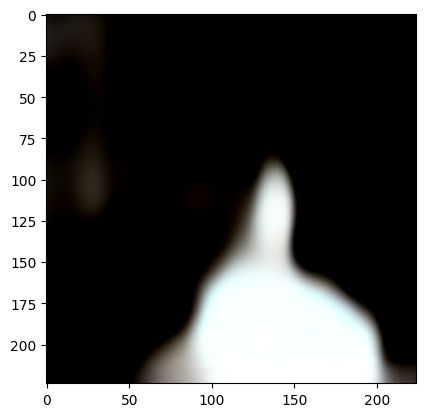

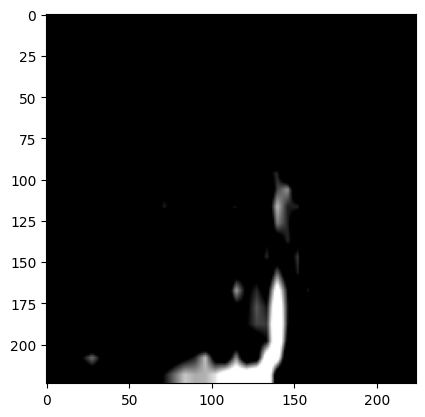

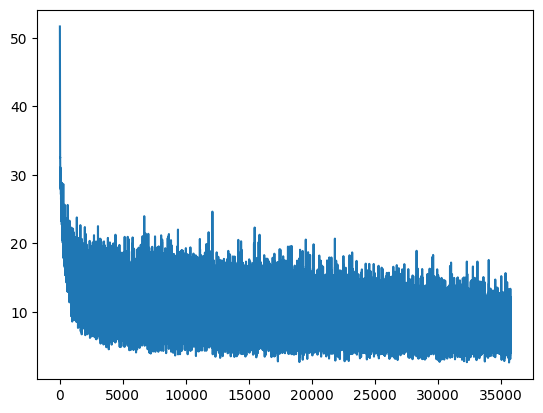

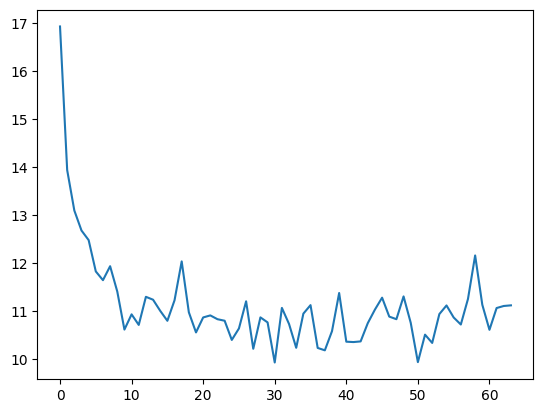

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                              | 23/60 [5:48:36<9:16:12, 901.95s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a45f810>, test/blurry_pixcorr=0.461, test/loss=11.1, test/loss_clip_total=0.443, test/loss_prior=0.356, test/num_steps=64, test/test_bwd_pct_correct=0.863, test/test_fwd_pct_correct=0.865, train/blurry_pixcorr=0.864, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.37, train/loss_

[E63/100 I0/559]
  Loss 6.717020034790039
[E63/100 I50/559]
  Loss 9.026878356933594
[E63/100 I100/559]
  Loss 10.593770980834961
[E63/100 I150/559]
  Loss 7.336571216583252
[E63/100 I200/559]
  Loss 6.383022308349609
[E63/100 I250/559]
  Loss 9.11762809753418
[E63/100 I300/559]
  Loss 8.475103378295898
[E63/100 I350/559]
  Loss 8.219026565551758
[E63/100 I400/559]
  Loss 7.429649353027344
[E63/100 I450/559]
  Loss 5.651578903198242
[E63/100 I500/559]
  Loss 6.6109418869018555
[E63/100 I550/559]
  Loss 7.16914176940918

---Evaluating---



 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                               | 23/60 [6:03:31<9:16:12, 901.95s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a423710>, test/blurry_pixcorr=0.46, test/loss=11.2, test/loss_clip_total=0.448, test/loss_prior=0.357, test/num_steps=65, test/test_bwd_pct_correct=0.863, test/test_fwd_pct_correct=0.863, train/blurry_pixcorr=0.873, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.38, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 63 / 100


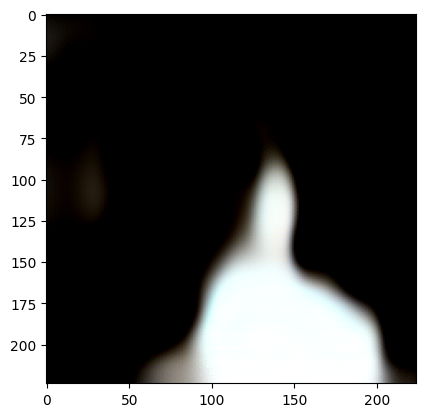

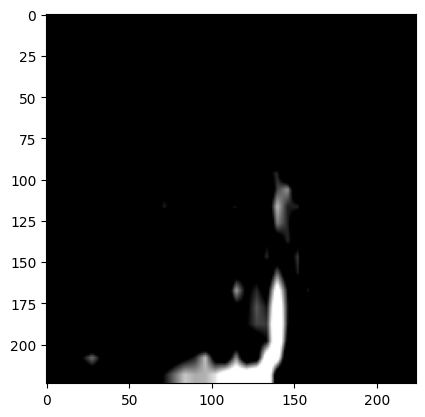

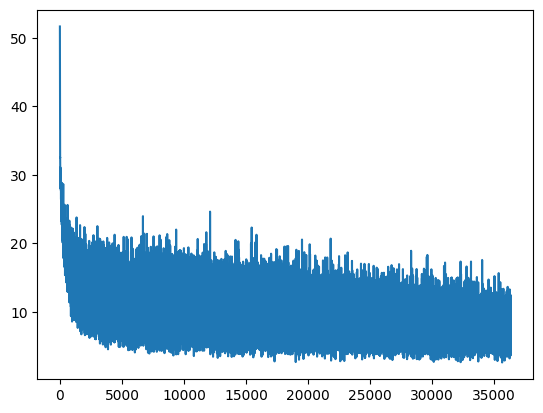

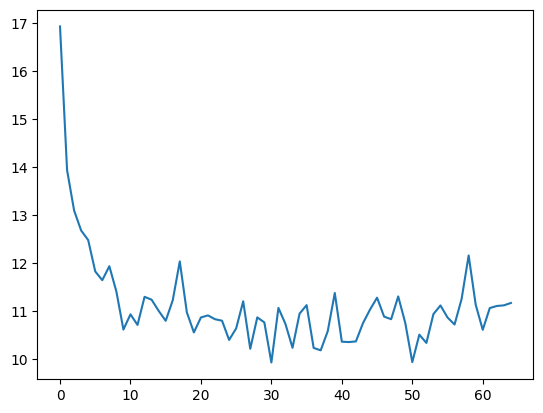

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                     | 24/60 [6:03:38<9:01:12, 902.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a423710>, test/blurry_pixcorr=0.46, test/loss=11.2, test/loss_clip_total=0.448, test/loss_prior=0.357, test/num_steps=65, test/test_bwd_pct_correct=0.863, test/test_fwd_pct_correct=0.863, train/blurry_pixcorr=0.873, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.38, train/loss

[E64/100 I0/559]
  Loss 10.107596397399902
[E64/100 I50/559]
  Loss 5.519496440887451
[E64/100 I100/559]
  Loss 4.799895286560059
[E64/100 I150/559]
  Loss 4.016152381896973
[E64/100 I200/559]
  Loss 11.480149269104004
[E64/100 I250/559]
  Loss 7.78573751449585
[E64/100 I300/559]
  Loss 10.697013854980469
[E64/100 I350/559]
  Loss 5.0609235763549805
[E64/100 I400/559]
  Loss 6.387118816375732
[E64/100 I450/559]
  Loss 6.057696342468262
[E64/100 I500/559]
  Loss 9.114620208740234
[E64/100 I550/559]
  Loss 5.547996997833252

---Evaluating---



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                      | 24/60 [6:18:33<9:01:12, 902.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e607390>, test/blurry_pixcorr=0.463, test/loss=10.7, test/loss_clip_total=0.424, test/loss_prior=0.343, test/num_steps=66, test/test_bwd_pct_correct=0.86, test/test_fwd_pct_correct=0.865, train/blurry_pixcorr=0.868, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.51, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep64 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 64 / 100


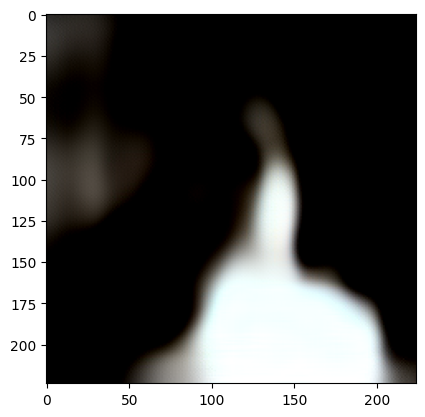

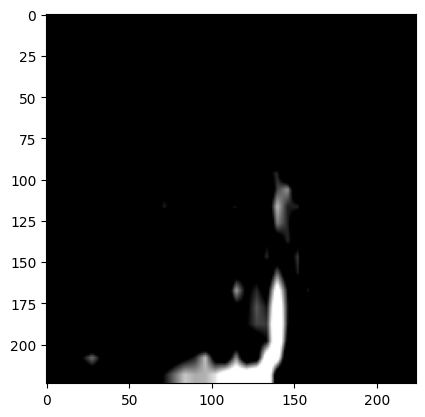

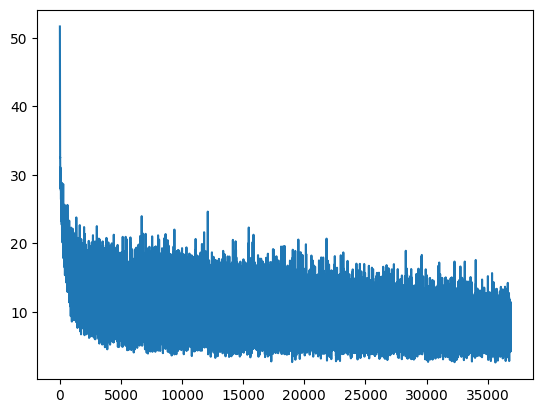

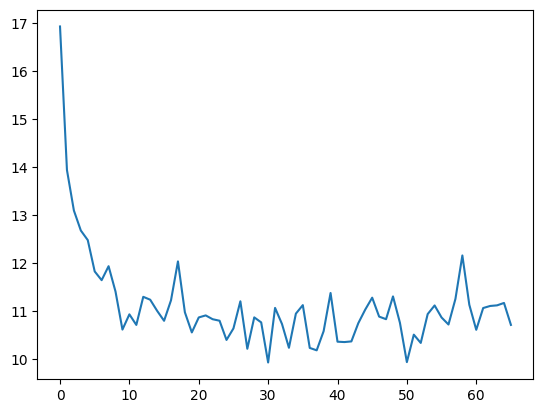

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                            | 25/60 [6:18:47<8:47:21, 904.05s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e607390>, test/blurry_pixcorr=0.463, test/loss=10.7, test/loss_clip_total=0.424, test/loss_prior=0.343, test/num_steps=66, test/test_bwd_pct_correct=0.86, test/test_fwd_pct_correct=0.865, train/blurry_pixcorr=0.868, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.51, train/los

[E65/100 I0/559]
  Loss 9.250374794006348
[E65/100 I50/559]
  Loss 9.6478853225708
[E65/100 I100/559]
  Loss 10.577197074890137
[E65/100 I150/559]
  Loss 9.036791801452637
[E65/100 I200/559]
  Loss 8.024214744567871
[E65/100 I250/559]
  Loss 6.004049301147461
[E65/100 I300/559]
  Loss 5.57718563079834
[E65/100 I350/559]
  Loss 6.521040439605713
[E65/100 I400/559]
  Loss 6.9758782386779785
[E65/100 I450/559]
  Loss 10.043707847595215
[E65/100 I500/559]
  Loss 11.518786430358887
[E65/100 I550/559]
  Loss 9.075736045837402

---Evaluating---



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                           | 25/60 [6:33:42<8:47:21, 904.05s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e337850>, test/blurry_pixcorr=0.461, test/loss=10.9, test/loss_clip_total=0.401, test/loss_prior=0.349, test/num_steps=67, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.38, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 65 / 100


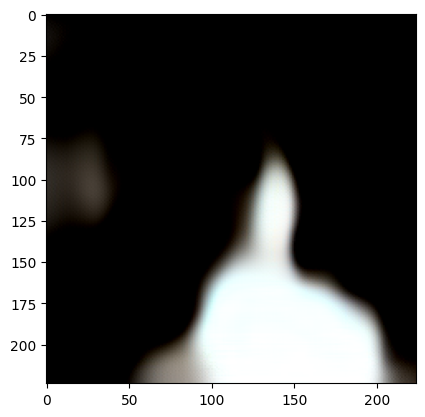

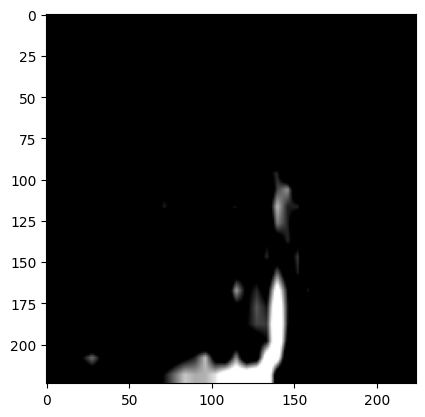

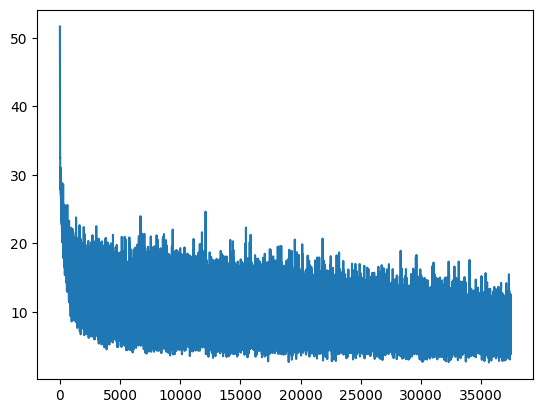

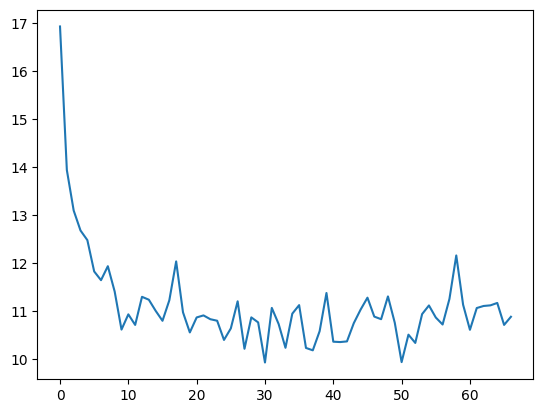

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                 | 26/60 [6:33:50<8:32:03, 903.63s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e337850>, test/blurry_pixcorr=0.461, test/loss=10.9, test/loss_clip_total=0.401, test/loss_prior=0.349, test/num_steps=67, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.38, train/loss

[E66/100 I0/559]
  Loss 10.31776237487793
[E66/100 I50/559]
  Loss 6.16187858581543
[E66/100 I100/559]
  Loss 6.946350574493408
[E66/100 I150/559]
  Loss 5.651458740234375
[E66/100 I200/559]
  Loss 4.536358833312988
[E66/100 I250/559]
  Loss 8.478921890258789
[E66/100 I300/559]
  Loss 5.82745361328125
[E66/100 I350/559]
  Loss 4.5168843269348145
[E66/100 I400/559]
  Loss 5.777287006378174
[E66/100 I450/559]
  Loss 7.969471454620361
[E66/100 I500/559]
  Loss 5.493038654327393
[E66/100 I550/559]
  Loss 8.133580207824707

---Evaluating---



 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                 | 26/60 [6:48:45<8:32:03, 903.63s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5b14d0>, test/blurry_pixcorr=0.46, test/loss=11.6, test/loss_clip_total=0.406, test/loss_prior=0.372, test/num_steps=68, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.17, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 66 / 100


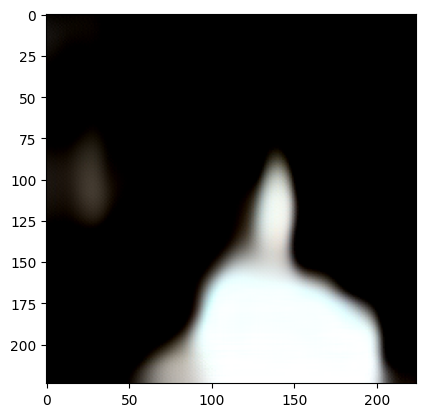

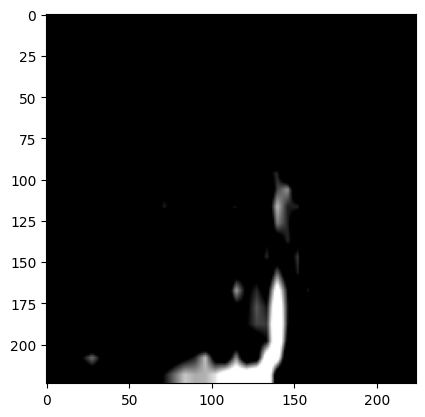

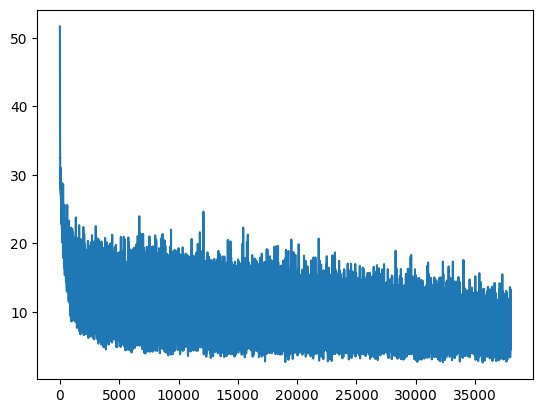

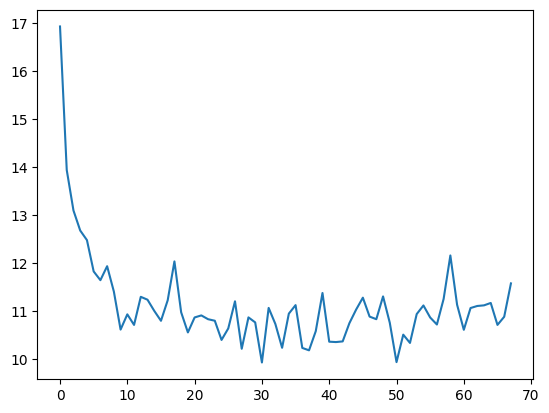

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                       | 27/60 [6:48:52<8:16:50, 903.36s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5b14d0>, test/blurry_pixcorr=0.46, test/loss=11.6, test/loss_clip_total=0.406, test/loss_prior=0.372, test/num_steps=68, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.17, train/loss

[E67/100 I0/559]
  Loss 10.463224411010742
[E67/100 I50/559]
  Loss 6.778840065002441
[E67/100 I100/559]
  Loss 5.3809099197387695
[E67/100 I150/559]
  Loss 5.190523147583008
[E67/100 I200/559]
  Loss 6.96181583404541
[E67/100 I250/559]
  Loss 6.8244428634643555
[E67/100 I300/559]
  Loss 6.83493709564209
[E67/100 I350/559]
  Loss 6.616570472717285
[E67/100 I400/559]
  Loss 7.300393104553223
[E67/100 I450/559]
  Loss 9.9624605178833
[E67/100 I500/559]
  Loss 8.073457717895508
[E67/100 I550/559]
  Loss 5.703484535217285

---Evaluating---



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                       | 27/60 [7:03:48<8:16:50, 903.36s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a430a90>, test/blurry_pixcorr=0.461, test/loss=10.5, test/loss_clip_total=0.395, test/loss_prior=0.338, test/num_steps=69, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.874, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.15, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 67 / 100


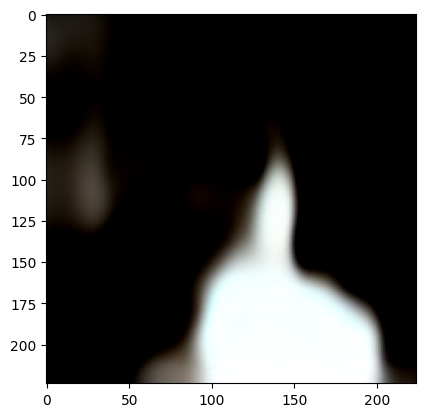

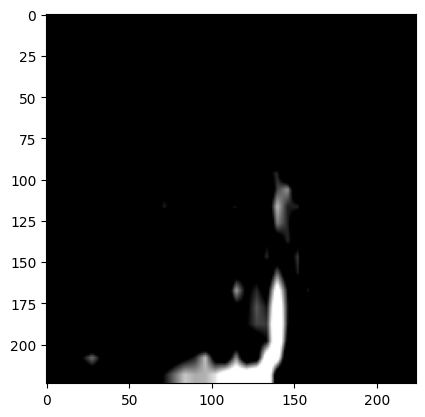

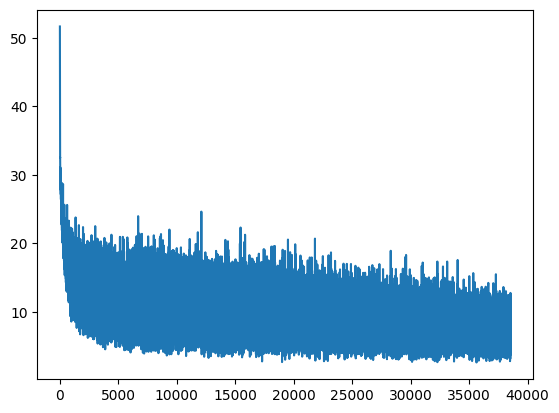

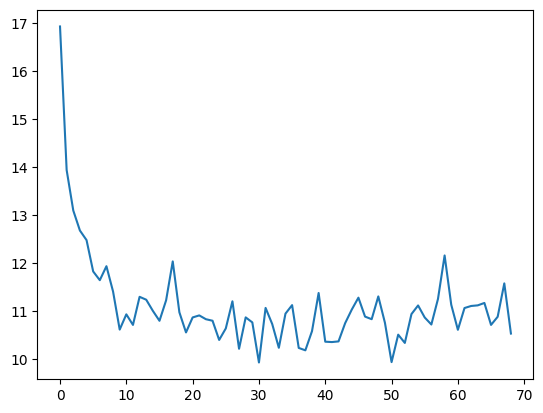

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                             | 28/60 [7:03:56<8:01:50, 903.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a430a90>, test/blurry_pixcorr=0.461, test/loss=10.5, test/loss_clip_total=0.395, test/loss_prior=0.338, test/num_steps=69, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.874, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.15, train/loss

[E68/100 I0/559]
  Loss 6.730836868286133
[E68/100 I50/559]
  Loss 6.664424896240234
[E68/100 I100/559]
  Loss 7.591571807861328
[E68/100 I150/559]
  Loss 4.115873336791992
[E68/100 I200/559]
  Loss 7.37949800491333
[E68/100 I250/559]
  Loss 6.767550468444824
[E68/100 I300/559]
  Loss 5.488520622253418
[E68/100 I350/559]
  Loss 6.967375755310059
[E68/100 I400/559]
  Loss 9.56149673461914
[E68/100 I450/559]
  Loss 4.708865165710449
[E68/100 I500/559]
  Loss 12.135994911193848
[E68/100 I550/559]
  Loss 7.975628852844238

---Evaluating---



 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                             | 28/60 [7:18:52<8:01:50, 903.47s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e743790>, test/blurry_pixcorr=0.462, test/loss=11.3, test/loss_clip_total=0.399, test/loss_prior=0.362, test/num_steps=70, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.875, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.33, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 68 / 100


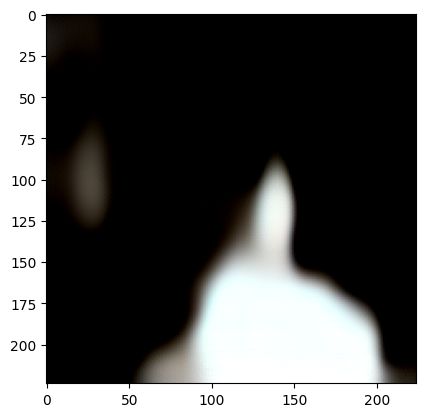

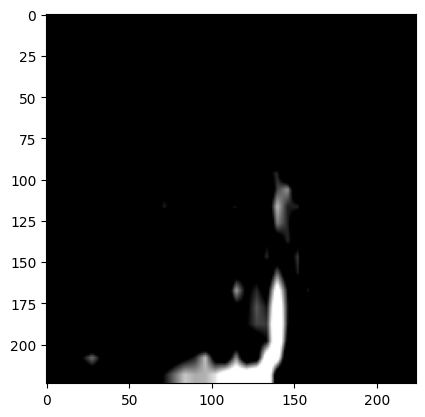

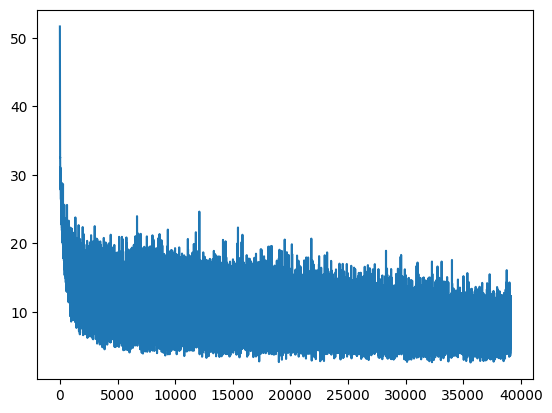

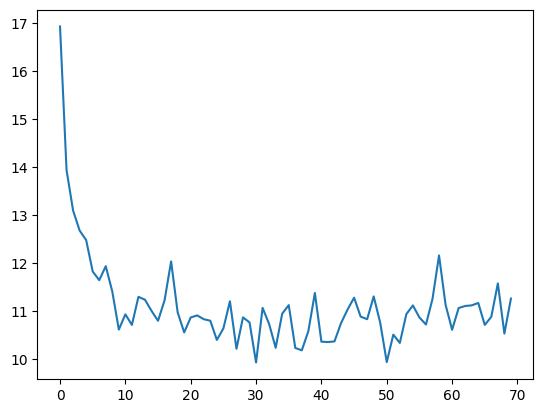

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                    | 29/60 [7:18:59<7:46:39, 903.21s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e743790>, test/blurry_pixcorr=0.462, test/loss=11.3, test/loss_clip_total=0.399, test/loss_prior=0.362, test/num_steps=70, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.875, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.33, train/los

[E69/100 I0/559]
  Loss 9.425786018371582
[E69/100 I50/559]
  Loss 8.550125122070312
[E69/100 I100/559]
  Loss 7.198594093322754
[E69/100 I150/559]
  Loss 5.027642250061035
[E69/100 I200/559]
  Loss 5.368453025817871
[E69/100 I250/559]
  Loss 6.199255466461182
[E69/100 I300/559]
  Loss 7.167617321014404
[E69/100 I350/559]
  Loss 3.706787347793579
[E69/100 I400/559]
  Loss 7.3634934425354
[E69/100 I450/559]
  Loss 8.7666597366333
[E69/100 I500/559]
  Loss 8.99761962890625
[E69/100 I550/559]
  Loss 6.0365376472473145

---Evaluating---



 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                    | 29/60 [7:33:55<7:46:39, 903.21s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e39e250>, test/blurry_pixcorr=0.46, test/loss=11.1, test/loss_clip_total=0.41, test/loss_prior=0.357, test/num_steps=71, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.874, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.17, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep69 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 69 / 100


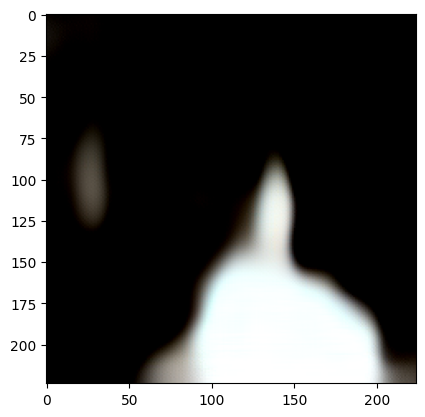

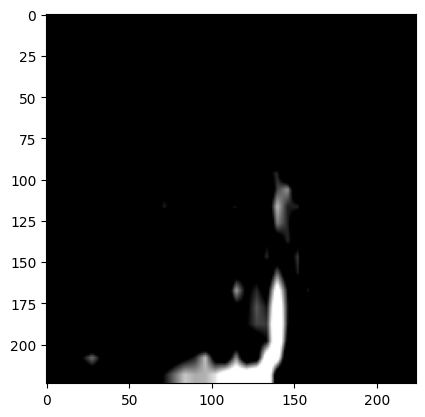

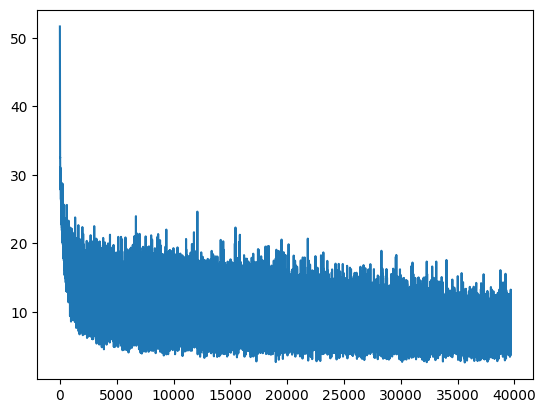

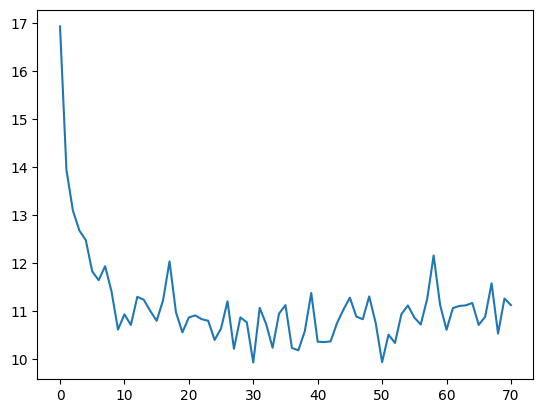

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 30/60 [7:34:08<7:32:34, 905.16s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e39e250>, test/blurry_pixcorr=0.46, test/loss=11.1, test/loss_clip_total=0.41, test/loss_prior=0.357, test/num_steps=71, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.871, train/blurry_pixcorr=0.874, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.17, train/loss

[E70/100 I0/559]
  Loss 3.223898410797119
[E70/100 I50/559]
  Loss 4.595545291900635
[E70/100 I100/559]
  Loss 8.640780448913574
[E70/100 I150/559]
  Loss 7.02672815322876
[E70/100 I200/559]
  Loss 7.56050443649292
[E70/100 I250/559]
  Loss 5.558802127838135
[E70/100 I300/559]
  Loss 6.6315155029296875
[E70/100 I350/559]
  Loss 7.073724746704102
[E70/100 I400/559]
  Loss 6.392745494842529
[E70/100 I450/559]
  Loss 7.276309490203857
[E70/100 I500/559]
  Loss 5.603635787963867
[E70/100 I550/559]
  Loss 6.518732070922852

---Evaluating---



 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 30/60 [7:49:04<7:32:34, 905.16s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a5e8590>, test/blurry_pixcorr=0.461, test/loss=10.3, test/loss_clip_total=0.408, test/loss_prior=0.329, test/num_steps=72, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.89, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 70 / 100


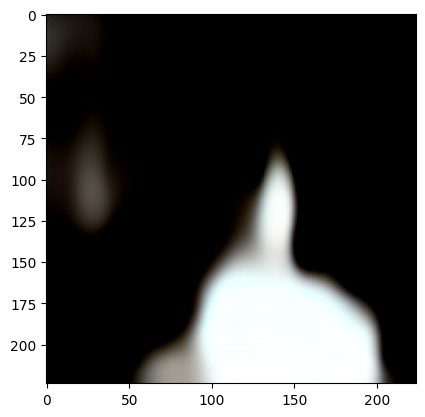

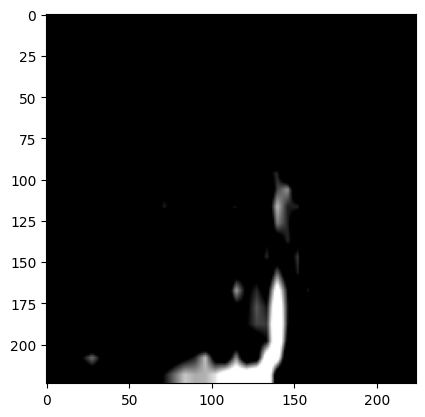

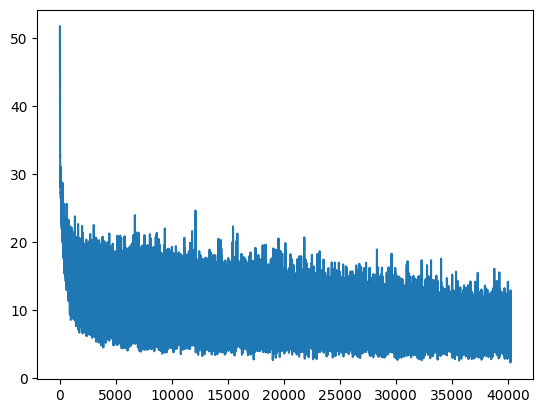

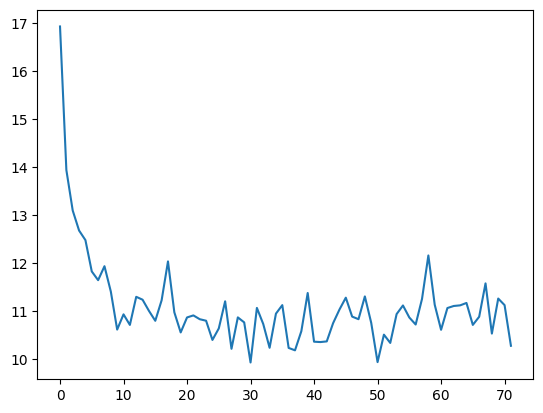

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 31/60 [7:49:12<7:17:11, 904.55s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a5e8590>, test/blurry_pixcorr=0.461, test/loss=10.3, test/loss_clip_total=0.408, test/loss_prior=0.329, test/num_steps=72, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.89, train/loss

[E71/100 I0/559]
  Loss 6.841289520263672
[E71/100 I50/559]
  Loss 9.225567817687988
[E71/100 I100/559]
  Loss 7.050479412078857
[E71/100 I150/559]
  Loss 5.145328521728516
[E71/100 I200/559]
  Loss 6.931973934173584
[E71/100 I250/559]
  Loss 9.120522499084473
[E71/100 I300/559]
  Loss 3.493406295776367
[E71/100 I350/559]
  Loss 7.083155632019043
[E71/100 I400/559]
  Loss 10.267099380493164
[E71/100 I450/559]
  Loss 5.955996513366699
[E71/100 I500/559]
  Loss 4.232386589050293
[E71/100 I550/559]
  Loss 5.345046520233154

---Evaluating---



 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 31/60 [8:04:08<7:17:11, 904.55s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a492090>, test/blurry_pixcorr=0.462, test/loss=11.5, test/loss_clip_total=0.407, test/loss_prior=0.371, test/num_steps=73, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.873, train/blurry_pixcorr=0.879, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.22, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 71 / 100


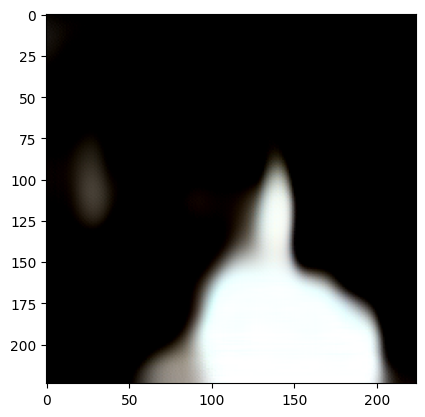

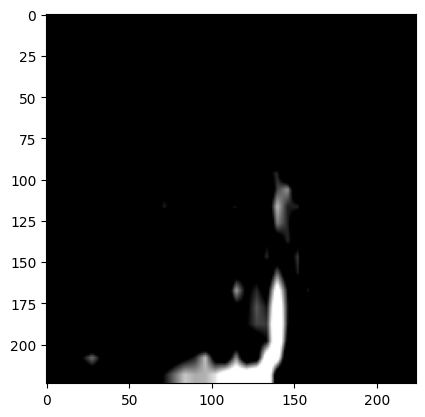

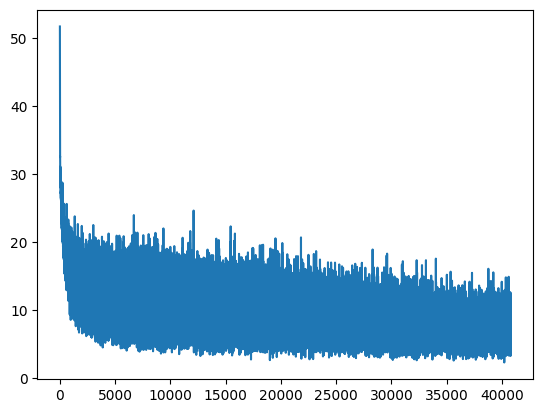

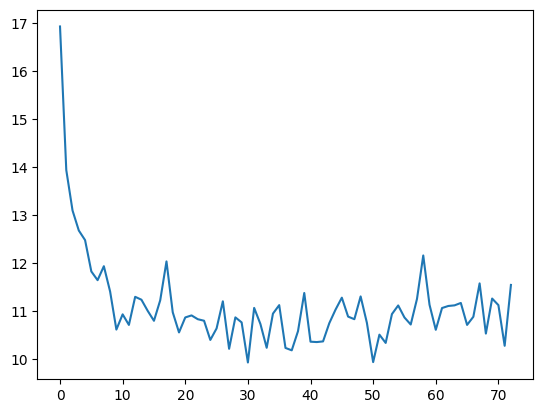

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 32/60 [8:04:15<7:01:57, 904.21s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a492090>, test/blurry_pixcorr=0.462, test/loss=11.5, test/loss_clip_total=0.407, test/loss_prior=0.371, test/num_steps=73, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.873, train/blurry_pixcorr=0.879, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.22, train/loss

[E72/100 I0/559]
  Loss 8.384151458740234
[E72/100 I50/559]
  Loss 5.712544918060303
[E72/100 I100/559]
  Loss 6.226810932159424
[E72/100 I150/559]
  Loss 9.103618621826172
[E72/100 I200/559]
  Loss 10.502962112426758
[E72/100 I250/559]
  Loss 11.892687797546387
[E72/100 I300/559]
  Loss 7.539698600769043
[E72/100 I350/559]
  Loss 6.26101016998291
[E72/100 I400/559]
  Loss 8.247099876403809
[E72/100 I450/559]
  Loss 6.150177478790283
[E72/100 I500/559]
  Loss 4.803844451904297
[E72/100 I550/559]
  Loss 10.152632713317871

---Evaluating---



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                      | 32/60 [8:19:10<7:01:57, 904.21s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a381d50>, test/blurry_pixcorr=0.461, test/loss=11.3, test/loss_clip_total=0.407, test/loss_prior=0.363, test/num_steps=74, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.88, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.07, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 72 / 100


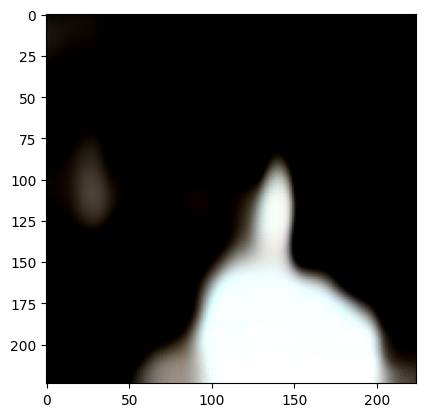

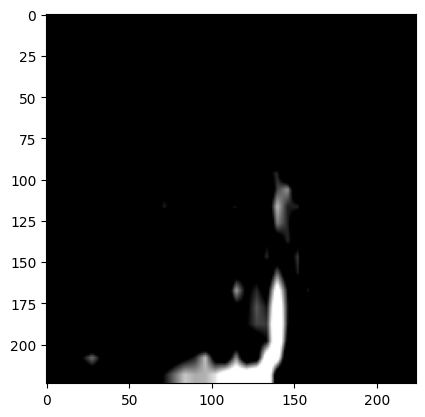

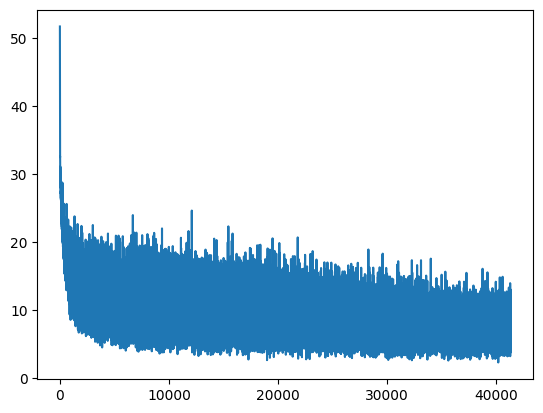

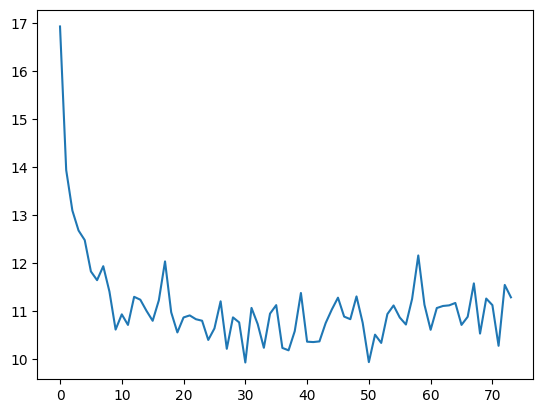

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 33/60 [8:19:17<6:46:34, 903.49s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a381d50>, test/blurry_pixcorr=0.461, test/loss=11.3, test/loss_clip_total=0.407, test/loss_prior=0.363, test/num_steps=74, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.88, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.07, train/loss

[E73/100 I0/559]
  Loss 5.740720272064209
[E73/100 I50/559]
  Loss 5.08408784866333
[E73/100 I100/559]
  Loss 5.210735321044922
[E73/100 I150/559]
  Loss 8.591830253601074
[E73/100 I200/559]
  Loss 9.372537612915039
[E73/100 I250/559]
  Loss 11.208725929260254
[E73/100 I300/559]
  Loss 7.649670600891113
[E73/100 I350/559]
  Loss 5.520630836486816
[E73/100 I400/559]
  Loss 6.497879505157471
[E73/100 I450/559]
  Loss 6.296028137207031
[E73/100 I500/559]
  Loss 7.108447074890137
[E73/100 I550/559]
  Loss 4.989400386810303

---Evaluating---



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 33/60 [8:34:09<6:46:34, 903.49s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a4a3710>, test/blurry_pixcorr=0.461, test/loss=10.6, test/loss_clip_total=0.409, test/loss_prior=0.34, test/num_steps=75, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.95, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 73 / 100


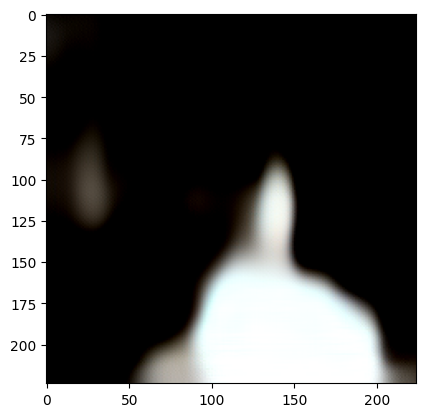

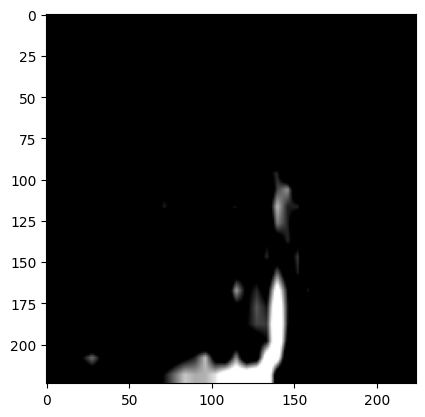

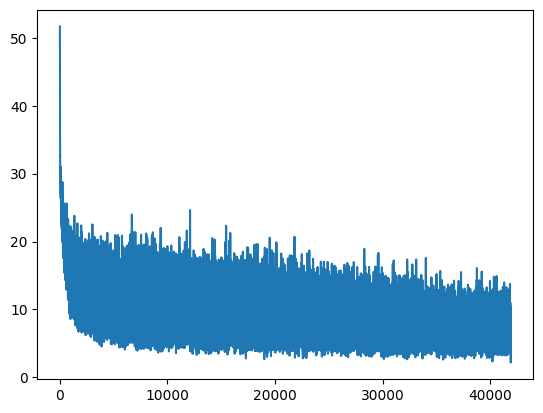

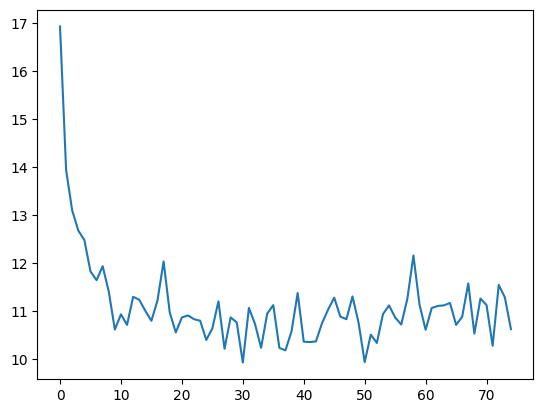

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                  | 34/60 [8:34:20<6:31:27, 903.37s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a4a3710>, test/blurry_pixcorr=0.461, test/loss=10.6, test/loss_clip_total=0.409, test/loss_prior=0.34, test/num_steps=75, test/test_bwd_pct_correct=0.873, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.95, train/loss

[E74/100 I0/559]
  Loss 6.305929183959961
[E74/100 I50/559]
  Loss 9.91713809967041
[E74/100 I100/559]
  Loss 5.926130294799805
[E74/100 I150/559]
  Loss 10.677186012268066
[E74/100 I200/559]
  Loss 6.480456829071045
[E74/100 I250/559]
  Loss 8.658758163452148
[E74/100 I300/559]
  Loss 6.215179443359375
[E74/100 I350/559]
  Loss 6.242734432220459
[E74/100 I400/559]
  Loss 8.471670150756836
[E74/100 I450/559]
  Loss 7.668676853179932
[E74/100 I500/559]
  Loss 10.043163299560547
[E74/100 I550/559]
  Loss 6.39982271194458

---Evaluating---



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                  | 34/60 [8:49:14<6:31:27, 903.37s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e21f490>, test/blurry_pixcorr=0.461, test/loss=11.5, test/loss_clip_total=0.411, test/loss_prior=0.37, test/num_steps=76, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.881, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.94, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep74 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 74 / 100


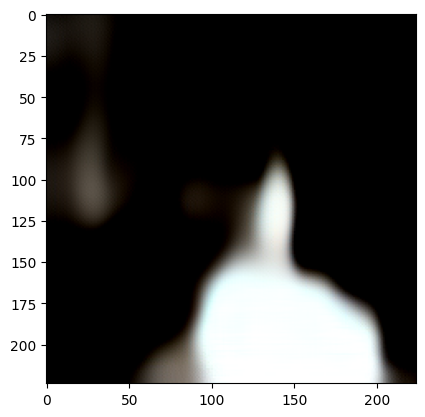

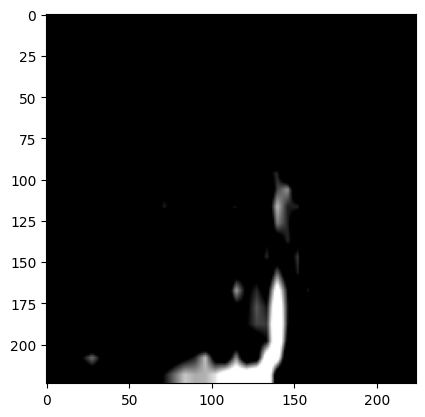

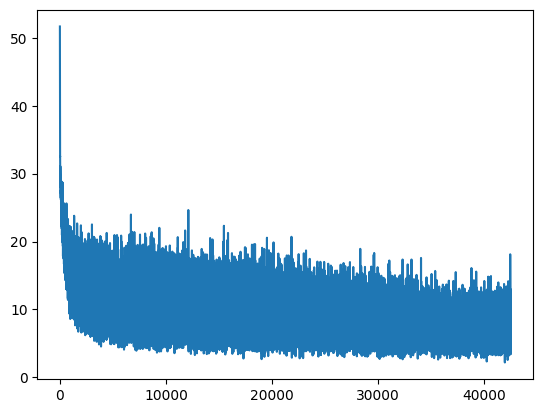

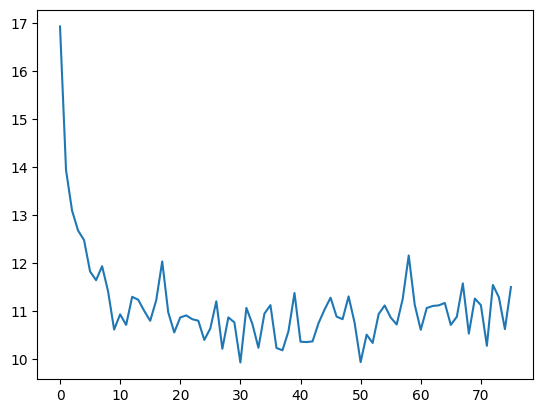

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 35/60 [8:49:27<6:16:55, 904.63s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e21f490>, test/blurry_pixcorr=0.461, test/loss=11.5, test/loss_clip_total=0.411, test/loss_prior=0.37, test/num_steps=76, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.881, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.94, train/loss

[E75/100 I0/559]
  Loss 4.998569011688232
[E75/100 I50/559]
  Loss 6.594184398651123
[E75/100 I100/559]
  Loss 3.927110195159912
[E75/100 I150/559]
  Loss 5.194737911224365
[E75/100 I200/559]
  Loss 5.046483516693115
[E75/100 I250/559]
  Loss 7.106989860534668
[E75/100 I300/559]
  Loss 5.710700988769531
[E75/100 I350/559]
  Loss 6.884591102600098
[E75/100 I400/559]
  Loss 9.144216537475586
[E75/100 I450/559]
  Loss 5.235722064971924
[E75/100 I500/559]
  Loss 8.203373908996582
[E75/100 I550/559]
  Loss 7.094320774078369

---Evaluating---



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 35/60 [9:04:22<6:16:55, 904.63s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7c8610>, test/blurry_pixcorr=0.461, test/loss=11.6, test/loss_clip_total=0.404, test/loss_prior=0.372, test/num_steps=77, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.98, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 75 / 100


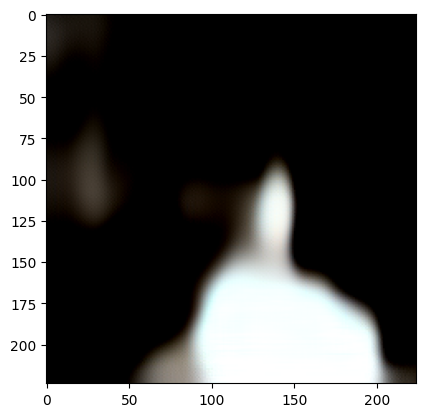

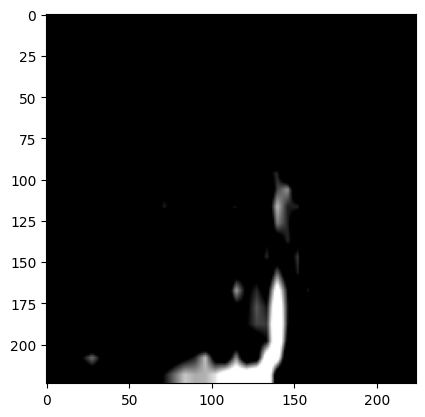

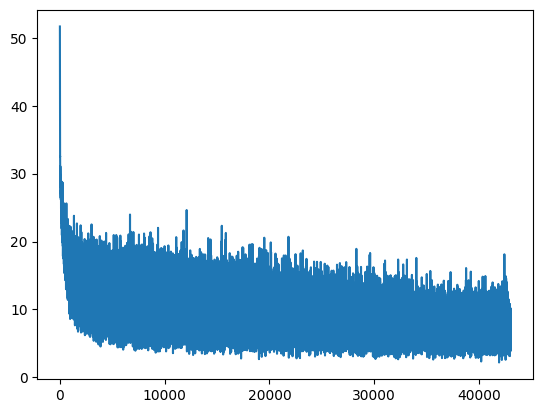

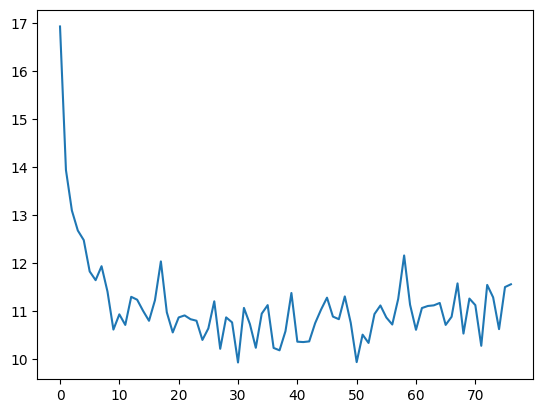

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                              | 36/60 [9:04:29<6:01:28, 903.68s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7c8610>, test/blurry_pixcorr=0.461, test/loss=11.6, test/loss_clip_total=0.404, test/loss_prior=0.372, test/num_steps=77, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.885, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.98, train/los

[E76/100 I0/559]
  Loss 9.938538551330566
[E76/100 I50/559]
  Loss 8.915755271911621
[E76/100 I100/559]
  Loss 5.295320987701416
[E76/100 I150/559]
  Loss 4.759804725646973
[E76/100 I200/559]
  Loss 8.02562141418457
[E76/100 I250/559]
  Loss 6.058113098144531
[E76/100 I300/559]
  Loss 7.434255123138428
[E76/100 I350/559]
  Loss 8.558370590209961
[E76/100 I400/559]
  Loss 5.391334533691406
[E76/100 I450/559]
  Loss 8.707420349121094
[E76/100 I500/559]
  Loss 6.504901885986328
[E76/100 I550/559]
  Loss 7.705538749694824

---Evaluating---



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 36/60 [9:19:24<6:01:28, 903.68s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a1d9c50>, test/blurry_pixcorr=0.461, test/loss=10.5, test/loss_clip_total=0.414, test/loss_prior=0.338, test/num_steps=78, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.883, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.89, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 76 / 100


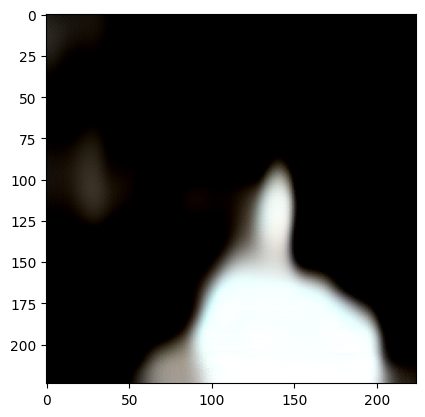

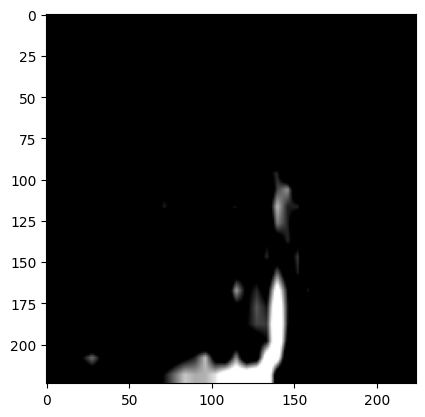

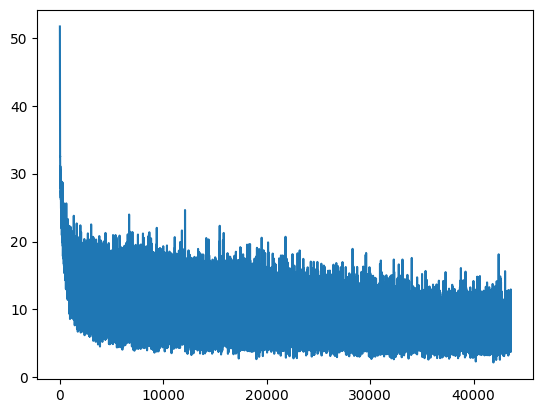

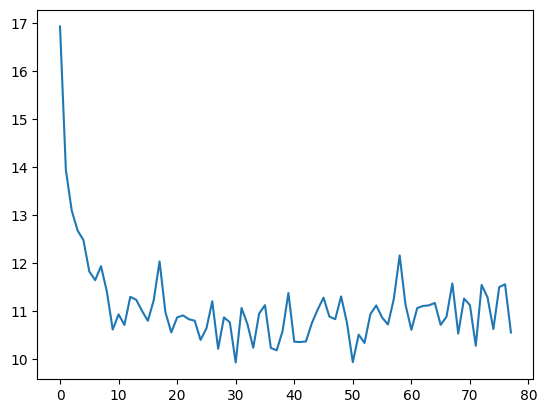

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                    | 37/60 [9:19:31<5:46:13, 903.19s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a1d9c50>, test/blurry_pixcorr=0.461, test/loss=10.5, test/loss_clip_total=0.414, test/loss_prior=0.338, test/num_steps=78, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.883, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.89, train/loss

[E77/100 I0/559]
  Loss 5.2298665046691895
[E77/100 I50/559]
  Loss 6.756771564483643
[E77/100 I100/559]
  Loss 6.444756984710693
[E77/100 I150/559]
  Loss 5.905081272125244
[E77/100 I200/559]
  Loss 6.804161071777344
[E77/100 I250/559]
  Loss 11.554365158081055
[E77/100 I300/559]
  Loss 8.24675464630127
[E77/100 I350/559]
  Loss 9.193056106567383
[E77/100 I400/559]
  Loss 8.256470680236816
[E77/100 I450/559]
  Loss 6.22506856918335
[E77/100 I500/559]
  Loss 7.43888521194458
[E77/100 I550/559]
  Loss 8.948720932006836

---Evaluating---



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 37/60 [9:34:26<5:46:13, 903.19s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a39b290>, test/blurry_pixcorr=0.461, test/loss=10.6, test/loss_clip_total=0.42, test/loss_prior=0.338, test/num_steps=79, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.869, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.93, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 77 / 100


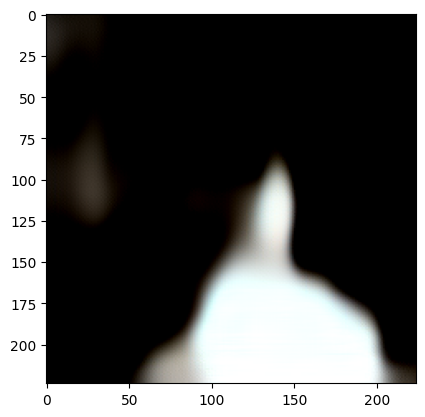

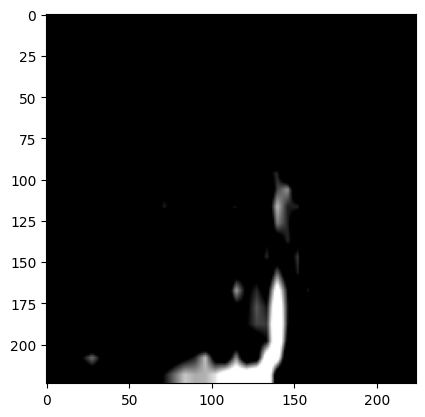

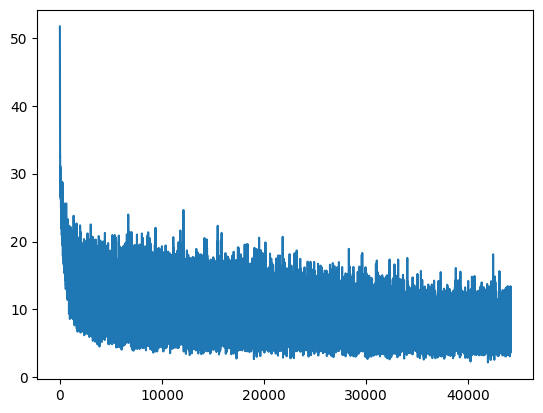

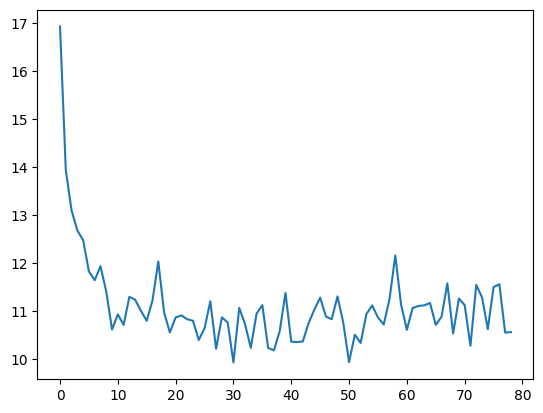

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                          | 38/60 [9:34:32<5:30:59, 902.69s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a39b290>, test/blurry_pixcorr=0.461, test/loss=10.6, test/loss_clip_total=0.42, test/loss_prior=0.338, test/num_steps=79, test/test_bwd_pct_correct=0.881, test/test_fwd_pct_correct=0.869, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.93, train/loss

[E78/100 I0/559]
  Loss 7.989117622375488
[E78/100 I50/559]
  Loss 9.264516830444336
[E78/100 I100/559]
  Loss 6.0864386558532715
[E78/100 I150/559]
  Loss 8.37442684173584
[E78/100 I200/559]
  Loss 6.612361431121826
[E78/100 I250/559]
  Loss 11.668194770812988
[E78/100 I300/559]
  Loss 5.876272201538086
[E78/100 I350/559]
  Loss 6.833148002624512
[E78/100 I400/559]
  Loss 7.404606819152832
[E78/100 I450/559]
  Loss 4.243318557739258
[E78/100 I500/559]
  Loss 7.508137226104736
[E78/100 I550/559]
  Loss 4.975857257843018

---Evaluating---



 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                          | 38/60 [9:49:27<5:30:59, 902.69s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a1029d0>, test/blurry_pixcorr=0.46, test/loss=11.1, test/loss_clip_total=0.403, test/loss_prior=0.356, test/num_steps=80, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.879, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.84, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 78 / 100


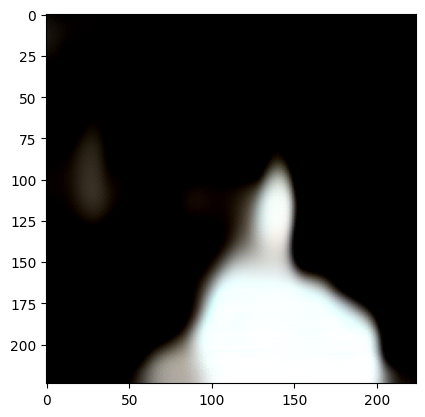

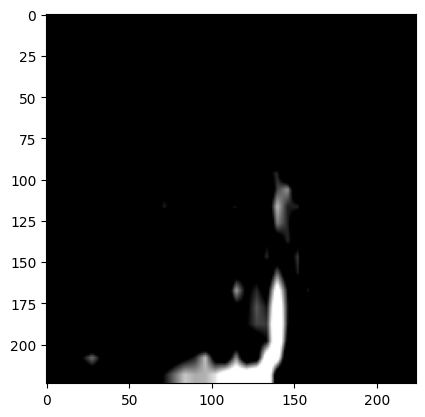

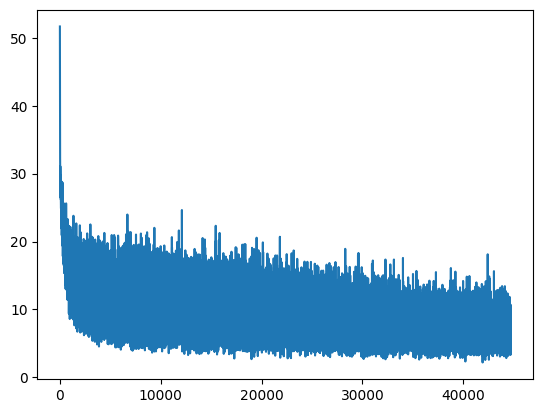

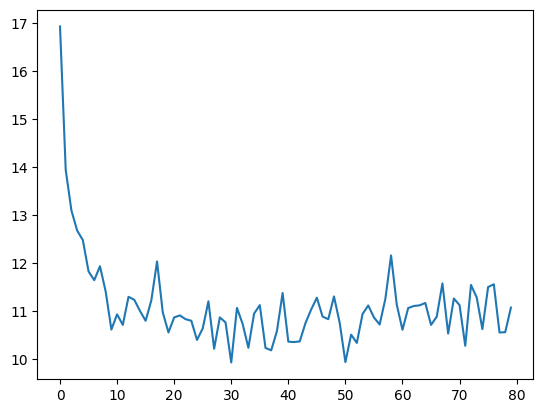

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 39/60 [9:49:34<5:15:50, 902.39s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a1029d0>, test/blurry_pixcorr=0.46, test/loss=11.1, test/loss_clip_total=0.403, test/loss_prior=0.356, test/num_steps=80, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.879, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.84, train/loss

[E79/100 I0/559]
  Loss 5.116720199584961
[E79/100 I50/559]
  Loss 5.284601211547852
[E79/100 I100/559]
  Loss 3.1952977180480957
[E79/100 I150/559]
  Loss 5.542369842529297
[E79/100 I200/559]
  Loss 5.270084381103516
[E79/100 I250/559]
  Loss 5.8918538093566895
[E79/100 I300/559]
  Loss 5.1622209548950195
[E79/100 I350/559]
  Loss 7.225070953369141
[E79/100 I400/559]
  Loss 6.570696830749512
[E79/100 I450/559]
  Loss 5.0943284034729
[E79/100 I500/559]
  Loss 8.980987548828125
[E79/100 I550/559]
  Loss 6.086260795593262

---Evaluating---



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 39/60 [10:04:31<5:15:50, 902.39s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a465690>, test/blurry_pixcorr=0.46, test/loss=12, test/loss_clip_total=0.423, test/loss_prior=0.385, test/num_steps=81, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.873, train/blurry_pixcorr=0.881, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.8, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep79 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 79 / 100


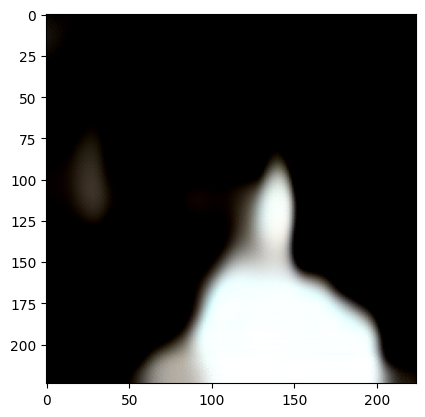

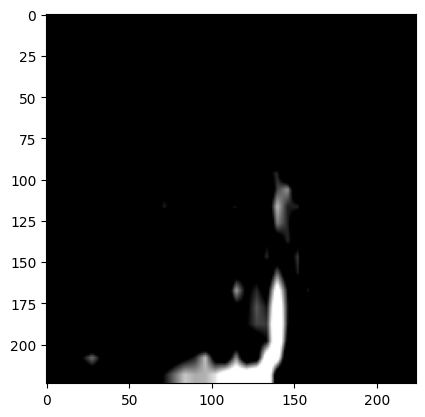

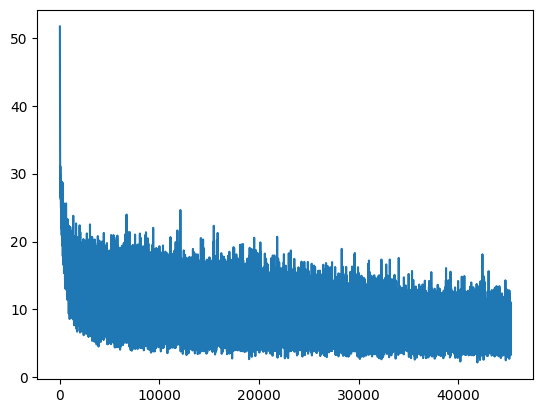

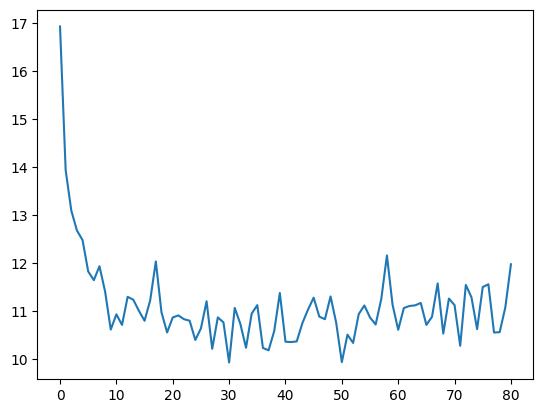

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 40/60 [10:04:45<5:01:37, 904.87s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a465690>, test/blurry_pixcorr=0.46, test/loss=12, test/loss_clip_total=0.423, test/loss_prior=0.385, test/num_steps=81, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.873, train/blurry_pixcorr=0.881, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.8, train/lo

[E80/100 I0/559]
  Loss 4.894959926605225
[E80/100 I50/559]
  Loss 7.353827476501465
[E80/100 I100/559]
  Loss 4.918349266052246
[E80/100 I150/559]
  Loss 5.448544979095459
[E80/100 I200/559]
  Loss 6.9676713943481445
[E80/100 I250/559]
  Loss 6.304314613342285
[E80/100 I300/559]
  Loss 6.052738189697266
[E80/100 I350/559]
  Loss 4.88602876663208
[E80/100 I400/559]
  Loss 5.058495044708252
[E80/100 I450/559]
  Loss 6.238742828369141
[E80/100 I500/559]
  Loss 8.316109657287598
[E80/100 I550/559]
  Loss 4.5962324142456055

---Evaluating---



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 40/60 [10:19:39<5:01:37, 904.87s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f92cc70a8d0>, test/blurry_pixcorr=0.46, test/loss=10.9, test/loss_clip_total=0.396, test/loss_prior=0.35, test/num_steps=82, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.885, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.76, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 80 / 100


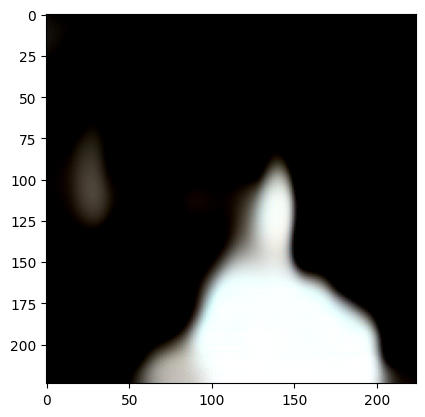

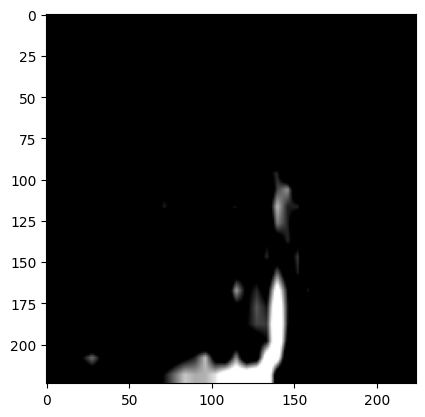

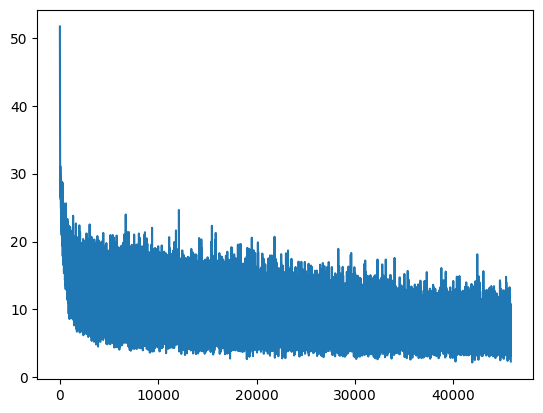

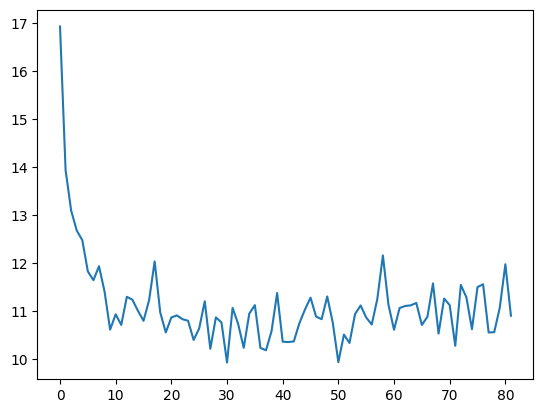

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 41/60 [10:19:46<4:46:11, 903.77s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f92cc70a8d0>, test/blurry_pixcorr=0.46, test/loss=10.9, test/loss_clip_total=0.396, test/loss_prior=0.35, test/num_steps=82, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.885, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.76, train/lo

[E81/100 I0/559]
  Loss 7.646216869354248
[E81/100 I50/559]
  Loss 6.117194175720215
[E81/100 I100/559]
  Loss 8.585587501525879
[E81/100 I150/559]
  Loss 6.520708084106445
[E81/100 I200/559]
  Loss 7.0045552253723145
[E81/100 I250/559]
  Loss 7.09379243850708
[E81/100 I300/559]
  Loss 4.90985631942749
[E81/100 I350/559]
  Loss 8.790997505187988
[E81/100 I400/559]
  Loss 4.742207050323486
[E81/100 I450/559]
  Loss 13.693268775939941
[E81/100 I500/559]
  Loss 9.482345581054688
[E81/100 I550/559]
  Loss 5.624365329742432

---Evaluating---



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 41/60 [10:34:41<4:46:11, 903.77s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7e1790>, test/blurry_pixcorr=0.46, test/loss=11.1, test/loss_clip_total=0.399, test/loss_prior=0.355, test/num_steps=83, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.88, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.77, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 81 / 100


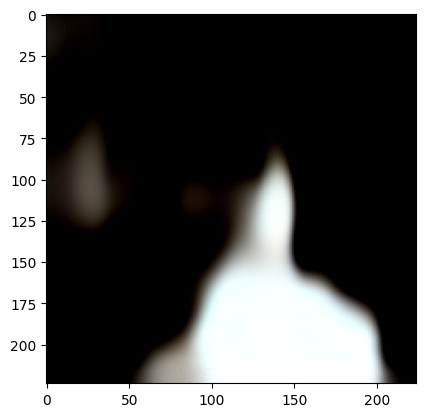

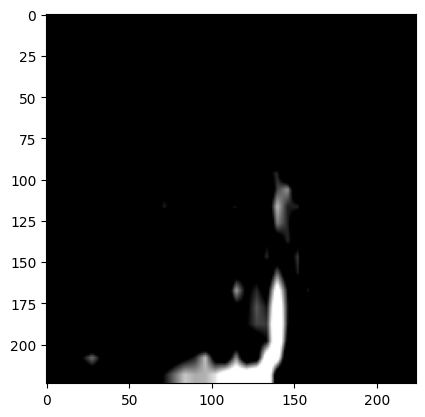

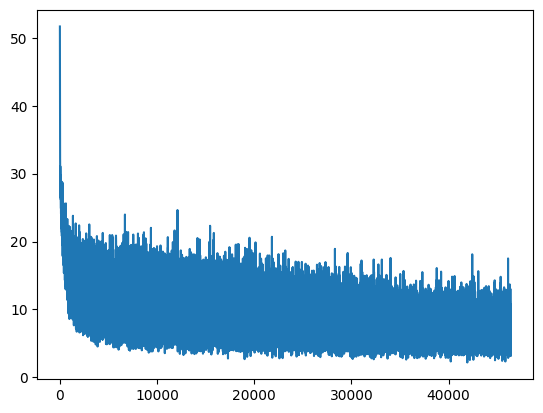

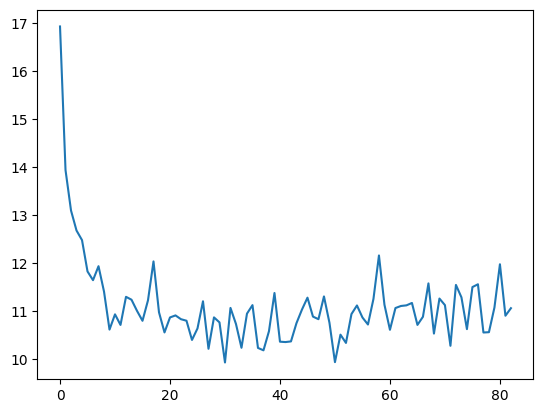

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 42/60 [10:34:48<4:30:57, 903.18s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7e1790>, test/blurry_pixcorr=0.46, test/loss=11.1, test/loss_clip_total=0.399, test/loss_prior=0.355, test/num_steps=83, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.88, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.77, train/loss

[E82/100 I0/559]
  Loss 4.78706693649292
[E82/100 I50/559]
  Loss 7.722226142883301
[E82/100 I100/559]
  Loss 5.770142555236816
[E82/100 I150/559]
  Loss 6.835422515869141
[E82/100 I200/559]
  Loss 5.248074054718018
[E82/100 I250/559]
  Loss 6.227529048919678
[E82/100 I300/559]
  Loss 7.78957986831665
[E82/100 I350/559]
  Loss 8.25918197631836
[E82/100 I400/559]
  Loss 5.028642177581787
[E82/100 I450/559]
  Loss 5.731939315795898
[E82/100 I500/559]
  Loss 7.833523273468018
[E82/100 I550/559]
  Loss 6.451360702514648

---Evaluating---



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 42/60 [10:49:43<4:30:57, 903.18s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e22a6d0>, test/blurry_pixcorr=0.46, test/loss=10.9, test/loss_clip_total=0.405, test/loss_prior=0.35, test/num_steps=84, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.885, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.75, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 82 / 100


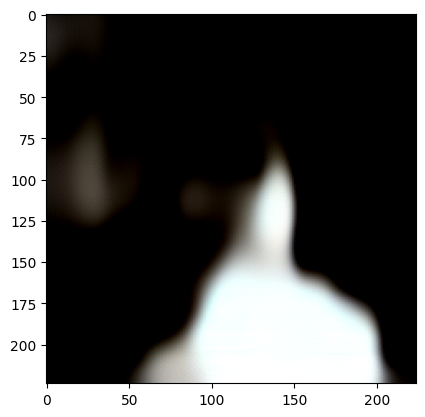

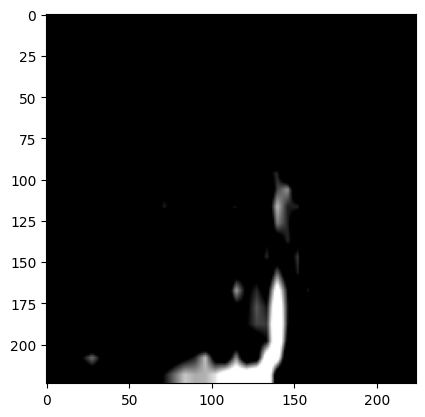

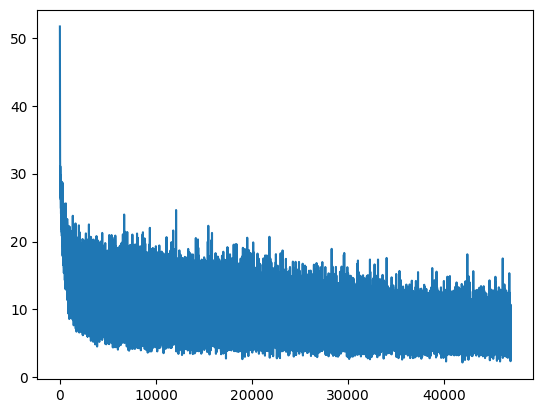

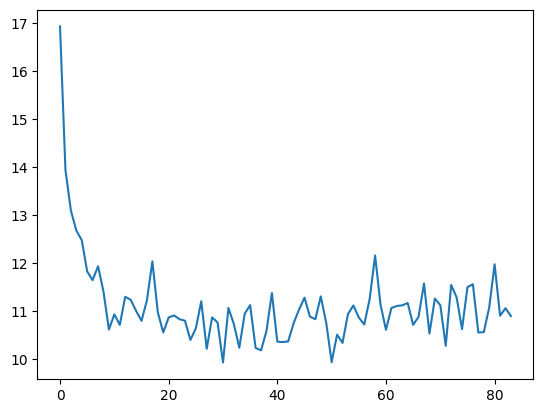

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 43/60 [10:49:52<4:15:57, 903.40s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e22a6d0>, test/blurry_pixcorr=0.46, test/loss=10.9, test/loss_clip_total=0.405, test/loss_prior=0.35, test/num_steps=84, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.879, train/blurry_pixcorr=0.885, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.75, train/lo

[E83/100 I0/559]
  Loss 8.714791297912598
[E83/100 I50/559]
  Loss 5.444189548492432
[E83/100 I100/559]
  Loss 3.6028499603271484
[E83/100 I150/559]
  Loss 8.87811279296875
[E83/100 I200/559]
  Loss 8.940130233764648
[E83/100 I250/559]
  Loss 5.33683967590332
[E83/100 I300/559]
  Loss 10.250161170959473
[E83/100 I350/559]
  Loss 6.77203369140625
[E83/100 I400/559]
  Loss 4.596956253051758
[E83/100 I450/559]
  Loss 5.488460540771484
[E83/100 I500/559]
  Loss 6.446058750152588
[E83/100 I550/559]
  Loss 6.832159042358398

---Evaluating---



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 43/60 [11:04:47<4:15:57, 903.40s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7ebc50>, test/blurry_pixcorr=0.46, test/loss=11.8, test/loss_clip_total=0.406, test/loss_prior=0.378, test/num_steps=85, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.85, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 83 / 100


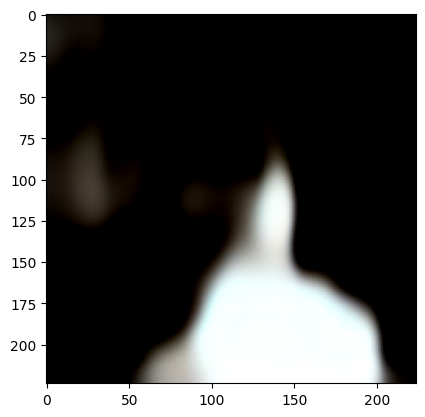

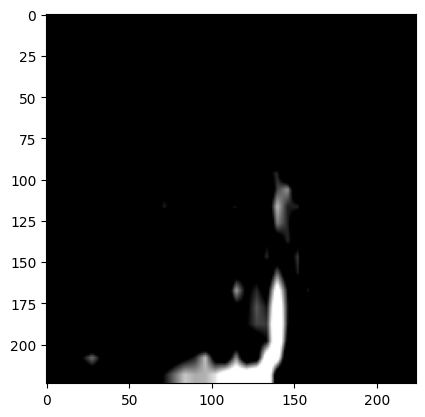

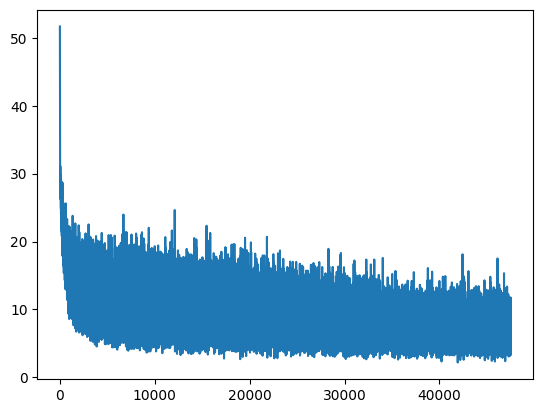

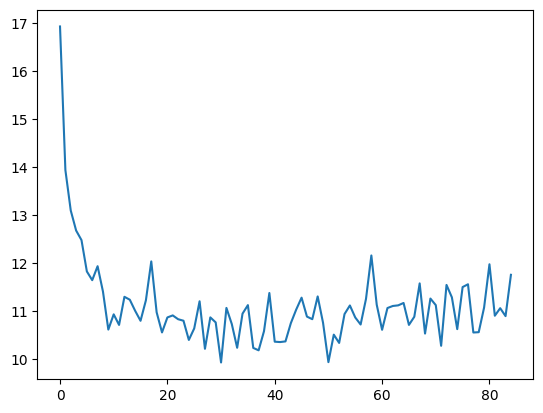

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 44/60 [11:04:54<4:00:50, 903.17s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e7ebc50>, test/blurry_pixcorr=0.46, test/loss=11.8, test/loss_clip_total=0.406, test/loss_prior=0.378, test/num_steps=85, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.875, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.85, train/los

[E84/100 I0/559]
  Loss 6.531800746917725
[E84/100 I50/559]
  Loss 4.032996654510498
[E84/100 I100/559]
  Loss 4.792510032653809
[E84/100 I150/559]
  Loss 10.269984245300293
[E84/100 I200/559]
  Loss 4.653905391693115
[E84/100 I250/559]
  Loss 7.772946834564209
[E84/100 I300/559]
  Loss 6.762738227844238
[E84/100 I350/559]
  Loss 5.285876274108887
[E84/100 I400/559]
  Loss 8.088553428649902
[E84/100 I450/559]
  Loss 7.037803649902344
[E84/100 I500/559]
  Loss 14.453073501586914
[E84/100 I550/559]
  Loss 5.721254825592041

---Evaluating---



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 44/60 [11:19:50<4:00:50, 903.17s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a2bc6d0>, test/blurry_pixcorr=0.46, test/loss=11.9, test/loss_clip_total=0.391, test/loss_prior=0.383, test/num_steps=86, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.74, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/ep84 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 84 / 100


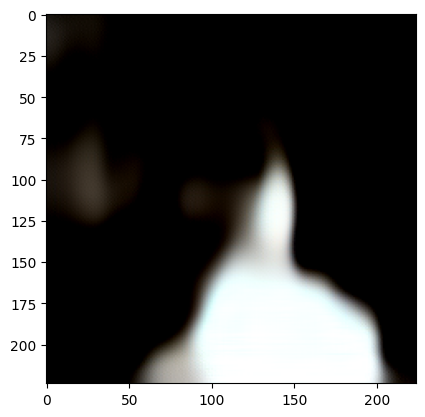

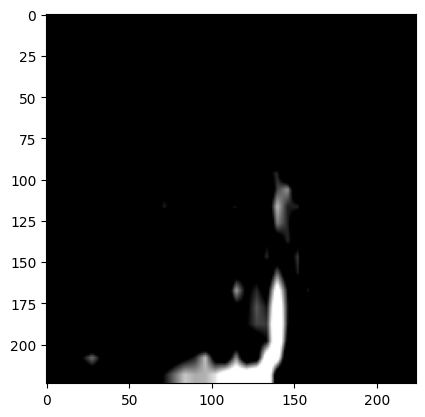

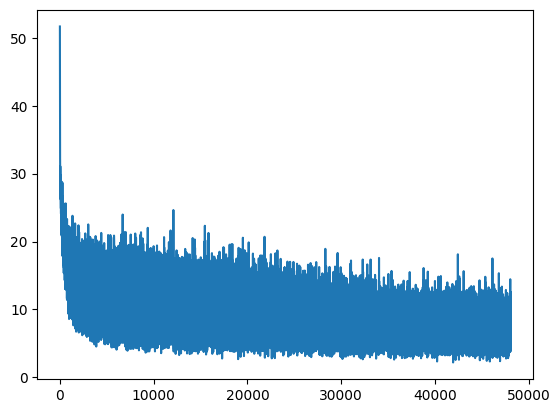

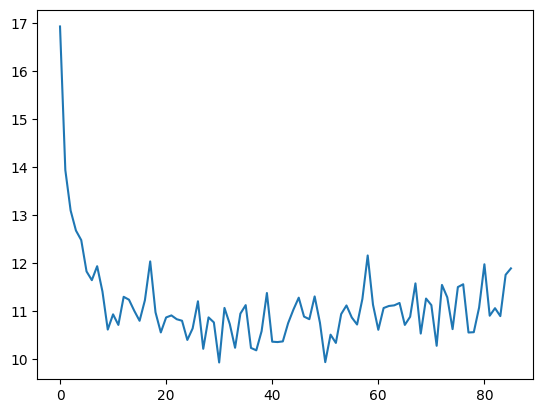

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 45/60 [11:20:04<3:46:14, 905.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f938a2bc6d0>, test/blurry_pixcorr=0.46, test/loss=11.9, test/loss_clip_total=0.391, test/loss_prior=0.383, test/num_steps=86, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.881, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.74, train/los

[E85/100 I0/559]
  Loss 10.666668891906738
[E85/100 I50/559]
  Loss 8.101469039916992
[E85/100 I100/559]
  Loss 5.515814781188965
[E85/100 I150/559]
  Loss 9.021138191223145
[E85/100 I200/559]
  Loss 6.854894161224365
[E85/100 I250/559]
  Loss 12.059903144836426
[E85/100 I300/559]
  Loss 7.4524617195129395
[E85/100 I350/559]
  Loss 5.7438788414001465
[E85/100 I400/559]
  Loss 4.747317314147949
[E85/100 I450/559]
  Loss 5.830740928649902
[E85/100 I500/559]
  Loss 6.856970310211182
[E85/100 I550/559]
  Loss 7.382112503051758

---Evaluating---



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 45/60 [11:34:59<3:46:14, 905.00s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5bdb90>, test/blurry_pixcorr=0.46, test/loss=11.7, test/loss_clip_total=0.397, test/loss_prior=0.378, test/num_steps=87, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.888, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.96, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__24-03-25_22-50/last ckpt!---

Finished epoch 85 / 100


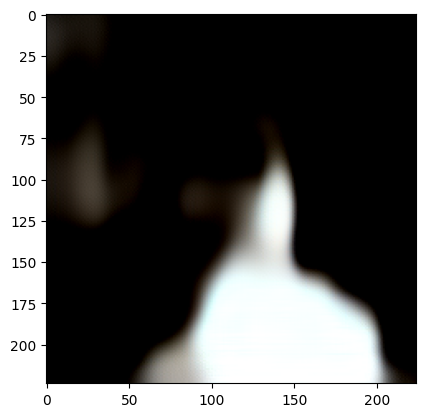

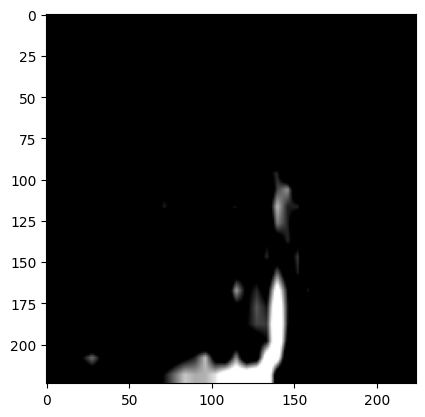

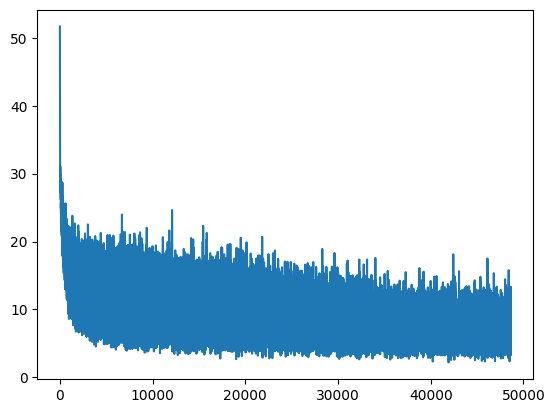

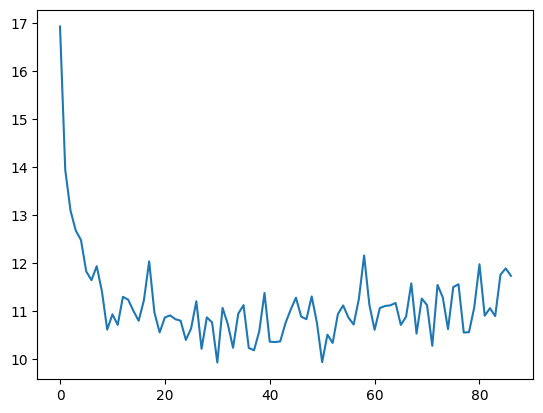

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 46/60 [11:35:06<3:30:59, 904.27s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5bdb90>, test/blurry_pixcorr=0.46, test/loss=11.7, test/loss_clip_total=0.397, test/loss_prior=0.378, test/num_steps=87, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.888, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.96, train/loss_

[E86/100 I0/559]
  Loss 5.175739765167236
[E86/100 I50/559]
  Loss 7.065819263458252
[E86/100 I100/559]
  Loss 8.232682228088379
[E86/100 I150/559]
  Loss 6.168227195739746
[E86/100 I200/559]
  Loss 9.720887184143066
[E86/100 I250/559]
  Loss 6.691470623016357


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 46/60 [11:41:32<3:33:30, 915.05s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f932e5bdb90>, test/blurry_pixcorr=0.46, test/loss=11.7, test/loss_clip_total=0.397, test/loss_prior=0.378, test/num_steps=87, test/test_bwd_pct_correct=0.883, test/test_fwd_pct_correct=0.877, train/blurry_pixcorr=0.888, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.96, train/loss_

KeyboardInterrupt: 

wandb: 
wandb: 🚀 View run csng_mouse_v1__24-03-25_22-50 at: https://wandb.ai/johnny1188/MindEye/runs/csng_mouse_v1__24-03-25_22-50
wandb: Find logs at: wandb/run-20250325_150141-csng_mouse_v1__24-03-25_22-50/logs


In [ ]:
### tracking
# epoch = 0
# losses, test_losses, lrs = [], [], []
# best = {"loss": 1e9, "epoch": 0}
torch.cuda.empty_cache()

### optimization
mse = nn.MSELoss()
l1 = nn.L1Loss()
cfg["model"]["cos_anneal_start"] = 0.004
cfg["model"]["cos_anneal_end"] = 0.0075
soft_loss_temps = utils.cosine_anneal(
    cfg["model"]["cos_anneal_start"],
    cfg["model"]["cos_anneal_end"],
    cfg["model"]["num_epochs"] - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])
)

### run
model.to(cfg["device"])
progress_bar = tqdm(range(epoch, cfg["model"]["num_epochs"]), ncols=1200, disable=False)
seed_all(cfg["seed"])
for epoch in progress_bar:
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    recon_cossim = 0.
    recon_mse = 0.
    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    loss_prior_total = 0.
    blurry_pixcorr = 0.

    train_dl = get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]]

    ### train
    model.train()
    for train_i, batch in enumerate(train_dl):
        if train_i % 50 == 0:
            print(f"[E{epoch}/{cfg['model']['num_epochs']} I{train_i}/{cfg['model']['num_iterations_per_epoch']}]")
        with torch.cuda.amp.autocast(dtype=cfg["data_type"]):
            optimizer.zero_grad()
            loss = 0.

            ### select data
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            ### augment image
            if cfg["model"]["use_image_aug"]: 
                image = img_augment(image)

            if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                betas = torch.cat(betas_list, dim=0).to(cfg["data_type"])
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                select = torch.cat(select_list, dim=0)

            ### map voxels to clip space
            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            ### map GT image to clip space
            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            ### normalize clip embeddings
            if cfg["model"]["clip_scale"] > 0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                if torch.isnan(loss_prior).any():
                    print(f"  Loss prior is NaN, skipping...")
                    del backbone, clip_voxels, blurry_image_enc_, clip_target, clip_voxels_norm, clip_target_norm, loss_prior, prior_out
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                for i in range(3):
                    if torch.isnan(loss_prior).any():
                        print(f"  Loss prior is NaN, trying again...")
                        del loss_prior, prior_out
                        torch.cuda.empty_cache()
                        loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    else:
                        break

                loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if cfg["model"]["clip_scale"] > 0:
                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp,
                    )

                loss_clip_total += loss_clip.item()
                loss_clip *= cfg["model"]["clip_scale"]
                loss += loss_clip

            if cfg["model"]["blurry_recon"]:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                # image_enc = autoenc.encode(2 * image - 1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image).latent_dist.mode() * 0.18215  # already z-scored
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                # image_norm = (image - mean) / std
                image_norm = image  # already z-scored
                # print(f"  Blurring Aug {image_norm.shape}")
                # image_aug = (blur_augs(image) - mean) / std
                image_aug = blur_augs(image)  # already z-scored
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1 * cont_loss) * cfg["model"]["blur_scale"] #/.18215

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if cfg["model"]["blurry_recon"]:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=max(len(image)//5, 1), replace=False)
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            if train_i % 50 == 0:
                print(f"  Loss {loss.item()}")
            utils.check_loss(loss)
            # accelerator.backward(loss)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if cfg["model"]["optimization"]["lr_scheduler_type"] is not None:
                lr_scheduler.step()

            optimizer.zero_grad()
            torch.cuda.empty_cache()

    ### evaluate
    print("\n---Evaluating---\n")
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=cfg["data_type"]):
        n_minibatches = 0
        test_loss=0.
        test_loss_clip_total = 0.
        test_loss_prior_total = 0.
        test_blurry_pixcorr = 0.
        test_fwd_percent_correct = 0.
        test_bwd_percent_correct = 0.
        eval_dl = get_dataloaders(config=cfg)[0]["val"][cfg["data_name"]]
        for batch in eval_dl:
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            clip_target = clip_img_embedder(image.float())
            if cfg["model"]["clip_scale"]>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, _ = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                test_loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                test_loss += loss_prior

            if cfg["model"]["clip_scale"]>0:
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                )

                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * cfg["model"]["clip_scale"]
                test_loss += loss_clip

            if cfg["model"]["blurry_recon"]:
                image_enc_pred, _ = blurry_image_enc_
                # blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample / 2 + 0.5).clamp(0,1)
                blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample)
                pixcorr = utils.pixcorr(image, blurry_recon_images)
                test_blurry_pixcorr += pixcorr.item()

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            n_minibatches += 1

        test_loss /= n_minibatches
        test_loss_clip_total /= n_minibatches
        test_loss_prior_total /= n_minibatches
        test_blurry_pixcorr /= n_minibatches
        test_fwd_percent_correct /= n_minibatches
        test_bwd_percent_correct /= n_minibatches

        utils.check_loss(test_loss)                
        test_losses.append(test_loss.item())

        if test_loss.item() < best["loss"]:
            save_ckpt(f'best')
            best["loss"] = test_loss.item()
            best["epoch"] = epoch

        logs = {
            "train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": test_loss.item(),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct,
            "test/test_bwd_pct_correct": test_bwd_percent_correct,
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total,
            "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
            "test/blurry_pixcorr": test_blurry_pixcorr,
            "train/recon_cossim": recon_cossim / (train_i + 1),
            "train/recon_mse": recon_mse / (train_i + 1),
            "train/loss_prior": loss_prior_total / (train_i + 1),
            "test/loss_prior": test_loss_prior_total,
        }

        # if finished training, save jpg recons if they exist
        if (epoch == cfg["model"]["num_epochs"]-1) or (epoch % cfg["model"]["ckpt_interval"] == 0):
            if cfg["model"]["blurry_recon"]:    
                # image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image[:4]).latent_dist.mode() * 0.18215  # already z-scored
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc[[j]]/0.18215).sample))
                    axes[jj].axis('off')
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc_pred[[j]]/0.18215).sample))
                    axes[jj].axis('off')

                if wandb_log:
                    logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

        progress_bar.set_postfix(**logs)

        if wandb_log: wandb.log(logs)

    # Save model checkpoint and reconstruct
    # if (ckpt_saving) and (epoch % ckpt_interval == 0):
    if (epoch + 1) % 5 == 0:
        save_ckpt(f'ep{epoch}')
    save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    # accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    print(f"Finished epoch {epoch} / {cfg['model']['num_epochs']}")
    
    plt.imshow(blurry_recon_images[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.imshow(image[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.plot(losses)
    plt.show()
    plt.plot(test_losses)
    plt.show()

print("\n===Finished!===\n")
save_ckpt(f'last')

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()